In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_theme("notebook")
sns.set_style("whitegrid")
sns.set_palette("Dark2")

# Постановка задачи и загрузка данных

В рамках лабораторной работы поработаем снова с реальными данными, содержательно близкими к данным минус первой лабораторной, - про учебные дисциплины. В этот раз займемся обработкой и генерацией описания и содержания дисциплин с помощью языковых моделей.

## Данные

Расположены по ссылке.

In [105]:
!gdown 1k1drlKxdqLgw_y_iMgSkBuZwa2Gjc6Q1

Downloading...
From: https://drive.google.com/uc?id=1k1drlKxdqLgw_y_iMgSkBuZwa2Gjc6Q1
To: /content/disciplines_2018_2022.csv
100% 78.8M/78.8M [00:00<00:00, 199MB/s]


Из информации о дисциплине у нас есть следующая:
1. `course_id` - номер дисциплины (может повторяться)
2. `course_title` - название дисциплины
3. `description` - краткое описание дисциплины
4. `up_id` - айди учебного плана (образовательной прогарммы)
5. `up_title` - название учебного плана (образовательной прогарммы)
6. `qualification` - уровень образования (бакалавриат или магистратура)
7. `start_year` - год набора
8. `module_name` - название модуля, в который входит дисциплина
9. `contents` – содержание дисциплины (все темы и разделы не по порядку, сплошным текстом)

Данные уже частично предобработаны: датасет содержит только те дисциплины, которые реализовывались более одного года. Это примерно треть от всех дисциплин за 2018–2022 гг.

In [106]:
df = pd.read_csv("/content/disciplines_2018_2022.csv")
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....


In [107]:
df.shape

(20502, 9)

Немного погрузимся в данные.

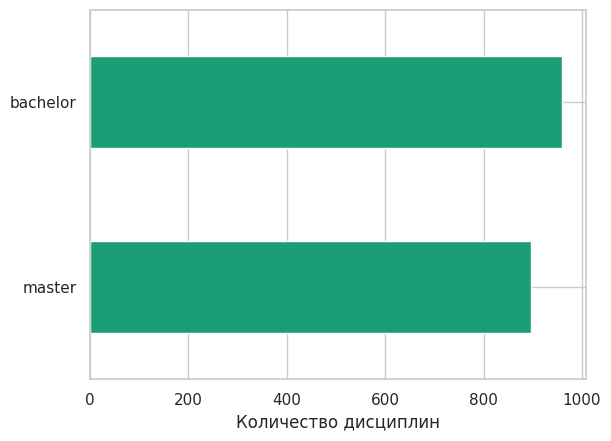

In [108]:
# количество дисциплин с уникальными названиями по уровням подготовки
df[["course_title", "qualification"]].drop_duplicates().qualification.value_counts().sort_values(ascending=True).plot(kind="barh")
plt.xlabel("Количество дисциплин")
plt.ylabel("")
plt.show()

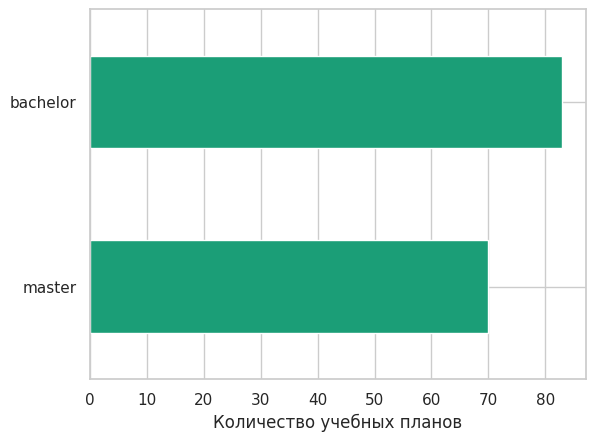

In [109]:
# количество учебных планов с уникальными названиями по уровням подготовки
df[["up_title", "qualification"]].drop_duplicates().qualification.value_counts().sort_values(ascending=True).plot(kind="barh")
plt.xlabel("Количество учебных планов")
plt.ylabel("")
plt.show()

Видим, что дисциплин больше (незначительно) в бакалавриате, но учебных планов больше в магистратуре. Это соответствует истине.

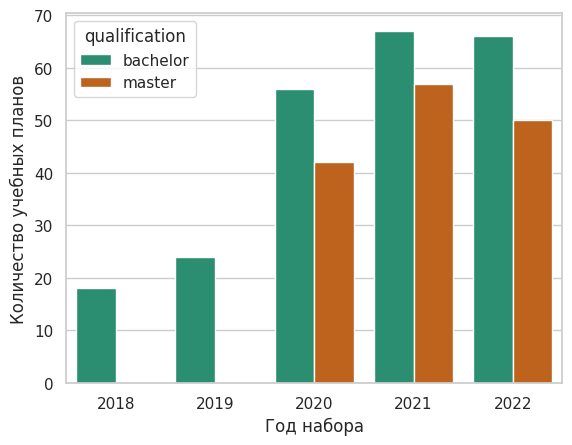

In [110]:
# количество учебных планов по годам и квалификациям
sns.barplot(data=df[["up_title", "qualification", "start_year"]].drop_duplicates().groupby(["start_year", "qualification"]).count().reset_index(), x="start_year", y="up_title", hue="qualification")
plt.ylabel("Количество учебных планов")
plt.xlabel("Год набора")
plt.show()

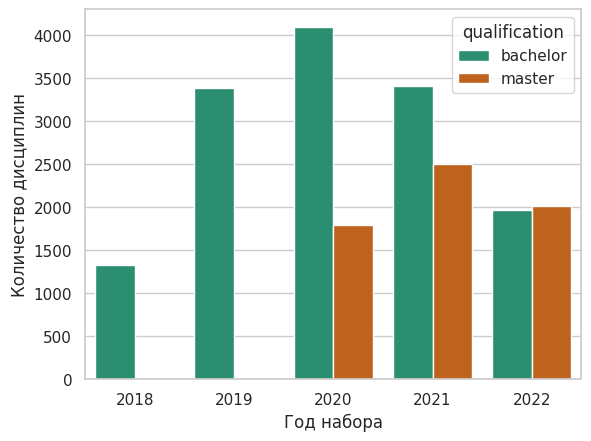

In [111]:
# количество дисциплин по годам и квалификациям
sns.barplot(data=df[["course_title", "qualification", "start_year"]].groupby(["start_year", "qualification"]).count().reset_index(), x="start_year", y="course_title", hue="qualification")
plt.ylabel("Количество дисциплин")
plt.xlabel("Год набора")
plt.show()

- Данные по магистратуре начали храниться с 2020 года, по бакалавриату – с 2018, поэтому графики выглядит именно так.
- Учебные планы могут существовать несколько лет с одним и тем же названием (как и дисциплины), поэтому в разрезе по годам уникальных записей больше, чем без него.

## Задача 1 – Предобработать description и contents
1. Выполнить предобработку текстовых данных. Минимально понадобятся следующие шаги предобработки:
  - приведение к одному регистру
  - токенизация
  - удаление пунктуации (можно оставить только буквенные символы в текстах)
  - лемматизация (можно использовать pymystem, он менее точный, чем pymorphy2, но работает в несколько раз быстрее)
2. Построить для дисциплины вектор на основе word2vec
3. Потестировать текстовые представления

Задач не много, но некоторые затратные по времени.

Для предобработки можно воспользовать материалами:
- https://colab.research.google.com/drive/1Lxe0_dPxF5_nNC1hnHTRc01rnMmUVCXa?usp=sharing
- https://colab.research.google.com/drive/16EFOsDbaTF2128kkVMqXxx2Xnb7Gr4mW?usp=share_link

### Предобработка текстовых данных

Проведите предобработку для столбца `contents`.

In [112]:
import nltk
from nltk.corpus import stopwords
import re
from pymystem3 import Mystem
from nltk.tokenize import word_tokenize


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

m = Mystem()

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', '', text)
    re.sub(r'\n', '', text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords.words('russian')]
    return [m.lemmatize(token)[0] for token in tokens]

df["contents_clean"] = df["contents"].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [114]:
# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_clean
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят..."


Проведите предобработку для столбца `description`.

In [115]:
df["description_clean"] = df["description"].apply(clean_text)

In [116]:
# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_clean,description_clean
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина...","[цель, курс, предоставлять, возможность, магис..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составлять, соответствие, требован..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[данный, дисциплина, учить, планировать, мероп..."


Данные минимально предобработаны. Можно переходить к векторизации. Рассмотрим два подхода:
- Word2Vec, обученный на предобработанных данных
- Tiny BERT – предобученная мини-версия мультиязычного BERT

### Кратко про языковые модели

Вне зависомости от того, большая модель или нет, данные, на которых она обучается и тестируется проходят одинаковые этапы предобработки.

Перед тем как начать обучение модели, необходимо подготовить текстовые данные. Этот процесс включает несколько этапов:

-	**Сбор данных.**

Модель обучается на большом корпусе текстов, который может включать книги, статьи, блоги, форумы и другие источники. Чем больше и разнообразнее данные, тем лучше модель сможет понять и воспроизвести язык.
-	**Токенизация.**

Процесс разбиения текста на отдельные элементы, называемые токенами. Токены могут представлять собой слова, части слов или даже отдельные символы. Например, фраза «Как дела?» может быть токенизирована как [«Как», «дела», «?»].
-	**Создание словарей.**

После токенизации формируется словарь, который сопоставляет с каждым токеном уникальный идентификатор. Этот словарь необходим для перевода текстовых данных в числовую форму, понятную модели.
-	**Преобразование текста в числовые векторы.**

Токены преобразуются в числовые векторы, которые будут использоваться в качестве входных данных для нейронной сети. Эти векторы могут быть статическими, как в Word2Vec, или динамическими, как в трансформерах.

---
Обучение языковой модели заключается в настройке её параметров на основе текстовых данных, чтобы она могла предсказывать следующее слово или генерировать осмысленные фразы.

-	**Forward propagation (прямой проход).**

На этом этапе данные проходят через слои нейронной сети, где каждое слово представляется в виде вектора. Эти векторы затем преобразуются в промежуточные состояния, которые несут информацию о контексте текста.
-	**Механизм внимания.**

В современных моделях, таких как трансформеры, используется механизм внимания, который позволяет модели выделять наиболее важные части текста, на которых нужно сосредоточиться при генерации или предсказании.
-	**Обратное распространение ошибки (Backpropagation).**

После того как модель сделала предсказание, она сравнивает его с реальными данными и вычисляет ошибку. Затем эта ошибка используется для корректировки параметров модели, чтобы улучшить точность предсказаний в будущем.
-	**Обучение на основе батчей.**

Данные разбиваются на небольшие группы — батчи, которые подаются модели для обучения. Этот метод позволяет эффективно использовать вычислительные ресурсы и ускорять процесс обучения.

Трансформеры
Современные языковые модели в большинстве основаны на архитектуре трансформеров, предложенной в 2017 году. Трансформеры решают многие проблемы, присущие RNN, и становятся доминирующим подходом в NLP.

-	**BERT (Bidirectional Encoder Representations from Transformers).**

Модель BERT использует двунаправленное обучение, что позволяет ей понимать контекст слова как слева, так и справа от него. Это делает BERT особенно мощным инструментом для задач, связанных с пониманием текста, таких как вопросо-ответные системы и анализ тональности.
-	**GPT (Generative Pre-Trained Transformer).**

Модель GPT, напротив, использует однонаправленное обучение, предсказывая следующее слово только на основе предыдущих слов. Эта модель, особенно в версиях GPT-2 и GPT-3, стала чрезвычайно популярной для генерации текста благодаря своей способности создавать связные и осмысленные сообщения, которые трудно отличить от текстов, написанных человеком.

### Векторизация word2vec

In [117]:
from gensim.models import Word2Vec
import gensim

In [118]:
# обучим на своих данных модель word2vec
# min_count – минимальная частота слова в корпусе
# vector_size – размер вектора для слова
# workers – количество потоков
# window – окно контекста, в которое попадает слово
tokens_list = df["contents_clean"] + df["description_clean"]
w2v_model = Word2Vec(tokens_list, min_count=1, vector_size=300, workers=2, window=10)

In [119]:
w2v_model_path = "w2v.bin" # будет удобно сохранить модель, если выполняете лабу не за один вечер
w2v_model.save(w2v_model_path)

In [120]:
# загрузка сохраненной модели
w2v_model = gensim.models.Word2Vec.load(w2v_model_path)

In [121]:
# так выглядит один вектор
print(w2v_model.wv.get_vector("обучение").shape)  # размер вектора
w2v_model.wv.get_vector("обучение")

(300,)


array([ 1.65061474e+00, -2.19855118e+00,  1.13672698e+00,  6.67065561e-01,
        3.19646406e+00, -1.94639042e-01,  2.00846601e+00,  4.88212490e+00,
       -5.98900938e+00, -2.08011031e+00,  5.58263636e+00,  3.10902143e+00,
        1.16910005e+00, -1.05085361e+00, -6.50131106e-01,  1.40190053e+00,
        3.35690165e+00,  3.18772221e+00, -8.69817972e-01, -2.33630252e+00,
       -9.51551273e-02,  1.57537803e-01,  1.64110267e+00, -5.71489930e-01,
        9.63217020e-01,  2.03420830e+00, -3.83906817e+00,  3.80562878e+00,
       -3.58278966e+00, -1.60748291e+00, -1.55170172e-01, -1.97442687e+00,
       -1.34541774e+00, -1.38429749e+00,  3.18534398e+00,  6.28090084e-01,
       -2.52445364e+00,  3.50610471e+00,  5.06648719e-01,  2.38683641e-01,
        1.85834098e+00,  1.08850265e+00,  2.79827142e+00,  2.20941281e+00,
        3.06511807e+00,  3.05222958e-01,  1.84151673e+00, -3.04567337e-01,
       -1.76970541e+00,  1.91232592e-01, -1.55088174e+00,  9.02590036e-01,
        2.57964301e+00,  

In [122]:
# слова, максимально близкие к "машинному обучению"
w2v_model.wv.most_similar(["обучение", "машинный"])

[('нейросеть', 0.45559707283973694),
 ('искусственный', 0.4552178978919983),
 ('crispdm', 0.45314767956733704),
 ('байесовский', 0.4506741762161255),
 ('подкрепление', 0.4501613676548004),
 ('глубокий', 0.4389115571975708),
 ('нейронный', 0.43805190920829773),
 ('фильтрация', 0.4310618042945862),
 ('коллаборативный', 0.429827481508255),
 ('ия', 0.42655259370803833)]

In [123]:
# слова, максимально близкие к "анализу данных"
w2v_model.wv.most_similar(["анализ", "данные"])

[('большой', 0.48497435450553894),
 ('анализировать', 0.46202224493026733),
 ('разметка', 0.44659847021102905),
 ('данный', 0.4430864453315735),
 ('исследование', 0.41860431432724),
 ('онфигурирование', 0.4136162996292114),
 ('биостатистика', 0.41346684098243713),
 ('учиться', 0.4127458930015564),
 ('экспериментальный', 0.4092208743095398),
 ('некомпозиционность', 0.40795809030532837)]

Семантически получились не идеальные, но в целом близкие списки. Это естественно, т.к. уникальных записей для обучения было передано около 2000.

Создадим два вектора для каждой дисциплины:
1. По данным содержания (`contents`)
2. По данным описание дисциплины (`description`)

Учитывайте, что должна быть возможность построить эмбеддинг для нового текста, даже если некоторые слова отсутствуют в исходной модели. При этом вектор не должен быть нулевым. Для этого напишите функцию `embed()`, в качестве агрументов принимающую список токенов текста и модель.

Вектором текста должно являться среднее всех векторов слов текста.

In [124]:
import numpy as np
def embed(tokens, w2v_model):
    vectors = [w2v_model.wv.get_vector(word) for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)


# пример вектора
embed(df.iloc[0].contents_clean, w2v_model)

array([ 2.81230330e-01,  4.79262620e-02, -9.63990331e-01, -1.22027926e-01,
        2.16157120e-02, -2.54836887e-01,  2.85126567e-01,  5.27973473e-01,
       -2.40906328e-03, -1.32831365e-01, -1.07472479e-01,  5.06382465e-01,
        3.04185122e-01,  2.55187213e-01,  8.91935885e-01, -7.32197046e-01,
       -6.57738507e-01, -1.53329045e-01,  7.34669641e-02, -6.73954368e-01,
       -1.96849883e-01, -1.15357243e-01,  1.03661343e-01, -1.01692721e-01,
       -1.19950819e+00,  7.25513935e-01,  1.10935247e+00, -7.75831699e-01,
       -1.69294333e+00,  3.96766424e-01,  1.32317722e-01, -8.97550490e-05,
        5.07654190e-01, -4.00858313e-01,  3.51736285e-02, -4.97571528e-01,
       -2.66105086e-01,  1.28957427e+00,  4.99561459e-01, -1.09020555e+00,
        4.07893419e-01, -9.38145071e-02, -8.73598039e-01,  7.33160675e-02,
       -1.09029758e+00, -9.46778417e-01,  5.40902913e-01,  6.86544836e-01,
        2.97812521e-01, -3.36057812e-01, -6.65442586e-01,  5.65378189e-01,
        3.96801293e-01,  

Теперь применим функцию `embed()` для формирования вектора для содержаний и кратких описаний в каждой записи.

In [125]:
df['contents_embed'] = df['contents_clean'].apply(lambda tokens: embed(tokens, w2v_model))
df['description_embed'] = df['description_clean'].apply(lambda tokens: embed(tokens, w2v_model))

# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_clean,description_clean,contents_embed,description_embed
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина...","[цель, курс, предоставлять, возможность, магис...","[-0.38693675, 0.6291646, -0.5498618, 0.0992287...","[0.09842246, 0.15820076, 0.05730357, 0.4940707..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составлять, соответствие, требован...","[-0.49982396, -0.6640689, 0.40284717, 0.637552...","[-0.04127117, -0.23387384, 0.26415184, 0.12894..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[данный, дисциплина, учить, планировать, мероп...","[0.06975979, 0.049133345, -0.6079057, 0.849385...","[-0.6946507, -0.4151105, 0.40943187, 0.3088083..."


Оценим, насколько семантически близки краткие описания дисциплин и темы в содержании. Для оценки воспользуемся косинусным сходством.

$$K(X, Y) = \frac{X \cdot Y} {||X||*||Y||}$$

В `sklearn` функция для расчета косинусного сходства генерирует матрицу результатов, мы будем сравнивать всего два вектора, поэтому напишем свою обертку для функции из `sklearn` так, чтобы она возвращала одно числовое значение, а не матрицу.

In [127]:
from sklearn.metrics.pairwise import cosine_similarity as cs

def cosine_similarity(vec1, vec2):
    return cs([vec1], [vec2])[0,0]

In [128]:
# посчитаем косинусное сходство
df["desc_cont_sim"] = df.apply(lambda x: cosine_similarity(x["contents_embed"], x["description_embed"]), axis=1)

Оценим по графику распределение сходств для всех дисциплин. Должен получиться график, похожий на гистограмму ниже. Пунктиром обозначено медианное значение.

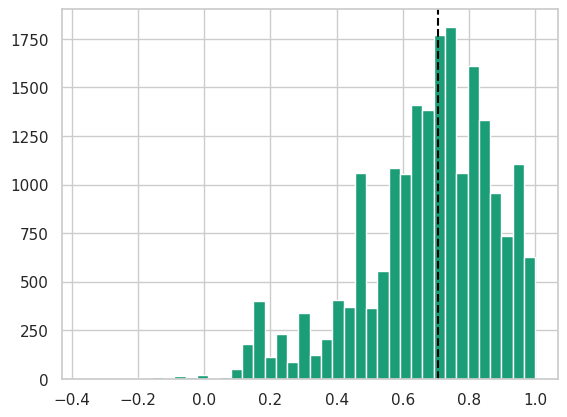

In [129]:
plt.hist(df['desc_cont_sim'], bins=40)
plt.axvline(np.median(df['desc_cont_sim']), color ='black', linestyle='--')
plt.show()

### Векторизация Tiny BERT

В качестве предобученной модели воспользуемся Tiny BERT – https://huggingface.co/sergeyzh/rubert-tiny-turbo

Она априори менее точная, чем базовый BERT, но строит эмбеддинги в разы быстрее.

In [130]:
# загружаем модель из библиотеки huggingface

from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer('sergeyzh/rubert-tiny-turbo')

> Если вы выполняете эту лабораторную локально, то возможны конфликты версии `sentence_transformers` и `tensorflow`, обычно решающиеся даунгрейдом `tensorflow`.

Прежде чем формировать эмбеддинги, объединим список токенов в строку.

In [131]:
def combine_tokens(text):
  return " ".join(text)

df['contents_clean_joined']=df['contents_clean'].apply(combine_tokens)
df['description_clean_joined']=df['description_clean'].apply(combine_tokens)

# пример результата преобразования
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_clean,description_clean,contents_embed,description_embed,desc_cont_sim,contents_clean_joined,description_clean_joined
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина...","[цель, курс, предоставлять, возможность, магис...","[-0.38693675, 0.6291646, -0.5498618, 0.0992287...","[0.09842246, 0.15820076, 0.05730357, 0.4940707...",0.480676,инновационный маркетинг корпоративный финансы ...,цель курс предоставлять возможность магистрант...
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составлять, соответствие, требован...","[-0.49982396, -0.6640689, 0.40284717, 0.637552...","[-0.04127117, -0.23387384, 0.26415184, 0.12894...",0.404958,математический модель сигнал помеха канал связ...,программа составлять соответствие требование о...
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[данный, дисциплина, учить, планировать, мероп...","[0.06975979, 0.049133345, -0.6079057, 0.849385...","[-0.6946507, -0.4151105, 0.40943187, 0.3088083...",0.640271,особенность организация массовый мероприятие п...,данный дисциплина учить планировать мероприяти...


Чтобы не генерировать несколько раз одинаковые векторы (в данных много неуникальных описаний и содеражний), оставим только уникальные, а затем присоединим их в исходную таблицу. Уникальных записей в разрезе описания и содержания около 2500.

>`tqdm.auto` позволяет в удобном формате добавлять прогресс-бар к некоторым методам `pandas` – например, `apply`, и получать метод `progress_apply`.

In [132]:
from tqdm.auto import tqdm
tqdm.pandas()

df_unique = df[['contents_clean_joined', 'description_clean_joined']].drop_duplicates()
df_unique['contents_bert_embedding'] = df_unique['contents_clean_joined'].progress_apply(lambda x: bert_model.encode(x))
df_unique['description_bert_embedding'] = df_unique['description_clean_joined'].progress_apply(lambda x: bert_model.encode(x))

  0%|          | 0/2525 [00:00<?, ?it/s]

  0%|          | 0/2525 [00:00<?, ?it/s]

Теперь присоедините полученную таблицу в исходный датафрейм.

In [133]:
df = df.merge(df_unique, on=['contents_clean_joined', 'description_clean_joined'], how='left')

# пример результата объединения
print(df.shape)
df.sample(3, random_state=42)

(20502, 18)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_clean,description_clean,contents_embed,description_embed,desc_cont_sim,contents_clean_joined,description_clean_joined,contents_bert_embedding,description_bert_embedding
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина...","[цель, курс, предоставлять, возможность, магис...","[-0.38693675, 0.6291646, -0.5498618, 0.0992287...","[0.09842246, 0.15820076, 0.05730357, 0.4940707...",0.480676,инновационный маркетинг корпоративный финансы ...,цель курс предоставлять возможность магистрант...,"[-0.01699407, -0.025533073, 0.025848273, -0.02...","[0.018506978, -0.03154075, 0.028918136, 0.0206..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составлять, соответствие, требован...","[-0.49982396, -0.6640689, 0.40284717, 0.637552...","[-0.04127117, -0.23387384, 0.26415184, 0.12894...",0.404958,математический модель сигнал помеха канал связ...,программа составлять соответствие требование о...,"[-0.015064588, 0.0021698757, 0.058785778, -0.0...","[0.030780545, -0.017179472, 0.020615265, -0.00..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[данный, дисциплина, учить, планировать, мероп...","[0.06975979, 0.049133345, -0.6079057, 0.849385...","[-0.6946507, -0.4151105, 0.40943187, 0.3088083...",0.640271,особенность организация массовый мероприятие п...,данный дисциплина учить планировать мероприяти...,"[0.017201137, -0.004298017, 0.012148312, -0.02...","[0.034545876, -0.008536334, -0.00068462203, 0...."


In [135]:
# размер вектора Tiny BERT – 312, что близко к размеру векторов w2v
df.contents_bert_embedding[0].shape

(312,)

In [136]:
df.description_bert_embedding[0].shape

(312,)

Повторим эксперимент из предыдущего раздела – оценим, насколько схожи векторы описания и содержания для одной дисциплины, сгенерированные BERT.

In [137]:
df["desc_cont_sim_bert"] = df.apply(lambda x: cosine_similarity(x["contents_bert_embedding"], x["description_bert_embedding"]), axis=1)

Постройте график. Вероятно, он будет похож на тот, что ниже.

Здесь снова пунктиром обозначена медиана.

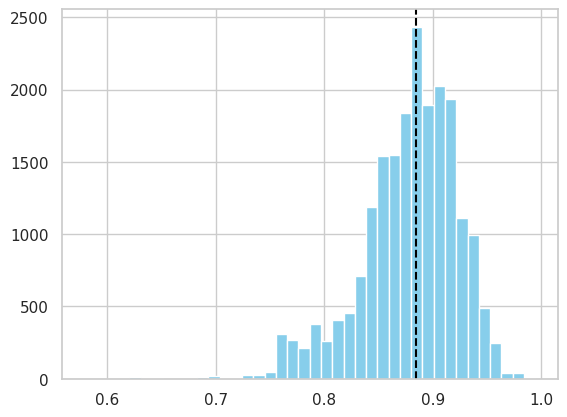

In [146]:
plt.hist(df['desc_cont_sim_bert'], bins=40, color="skyblue")
plt.axvline(np.median(df['desc_cont_sim_bert']), color ='black', linestyle='--')
plt.show()

Теперь сравните распределения сходств, полученных при использовании разных подходов к векторизации.

В результате должно получиться нечто похожее на гистограмму ниже. По ней видно, что вектора Tiny BERT дают более узкий диапазон сходств. И более высокие значения. Это можно объяснить тем, что:
- модель обучалась на более широком контексте и не улавливает тонкостей разных дисциплин
- относительно стандартного BERT качество модели сильно ниже (его можно поизучать по ссылке в начале раздела)

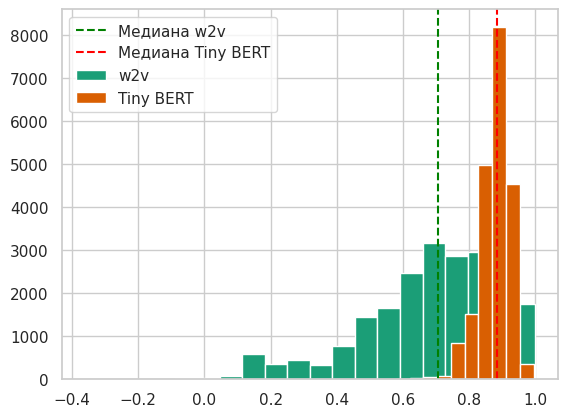

In [147]:
plt.figure()
plt.axvline(np.median(df['desc_cont_sim']), color='green', label='Медиана w2v', linestyle='--')
plt.axvline(np.median(df['desc_cont_sim_bert']), color='red', label='Медиана Tiny BERT', linestyle='--')
plt.hist(df['desc_cont_sim'], bins=20, label='w2v')
plt.hist(df['desc_cont_sim_bert'], label='Tiny BERT')
plt.legend()
plt.show()

## Задача 2 – Сгенерировать description и contents

Задача 2 – исследовательская. Надо проверить, как с работой преподавателя справится большая языковая модель. В исходных данных расположены описания и темы из содержания, написанные реальными людьми. Теперь используем LLM для той же задачи. Также рассмотрим, как разные техники промпт-инжиниринга будут влиять на результат.

### Техники промпт-инжиниринга

Под техникой промпт-инжиниринга (или промптинга) понимается практика разработки и оптимизации промптов (запросов, подсказок) к модели, которые помогут получить максимально близкий к ожидаемому ответ и эффективно взаимодействовать с языковой моделью. Это ключевой элемент в управлении работой и поведением LLM.


Наиболее популярными являются следующие техники:
1. **Zero-shot** (Обучение без примеров) – модель применяет общие знания и правила для решения новых задач.
2. **Few-shot** (Обучение на нескольких примерах) – модель адаптируется к новым задачам, используя небольшой набор примеров.
3. **Chain-of-thought** (Цепочка рассуждений) – модель генерирует пошаговое рассуждение для решения задачи, что помогает в понимании сложных задач и улучшает точность ответов.
4. **Tree of thoughts** (Дерево рассуждений) – подход, при котором рассматриваются различные варианты решений или идей, ветвящиеся от основной мысли.

В этой работе воспользуемся первыми двумя подходами.

В колабе слишком мало ресурсов (если пользоваться бесплатной версией), чтобы хотя бы запустить какую-нибудь интересную современную модель через модуль `transformers`, и тем более ресурсов не хватит для дообучения. Поэтому для тестирования воспользуемся API/serverless API.

Тестировать запросы будем к LLM mistral-nemo-instruct-2407 – https://huggingface.co/mistralai/Mistral-Nemo-Instruct-2407

Это дообученная instruct-версия модели mistral-nemo-base-2407 (12В). Модели категории Instruct способны генерировать ответ, следуя заданному им шаблону поведения.

Обе версии (base и instruct) мультиязычные и выпущены MistralAI и NVIDIA в июле 2024.

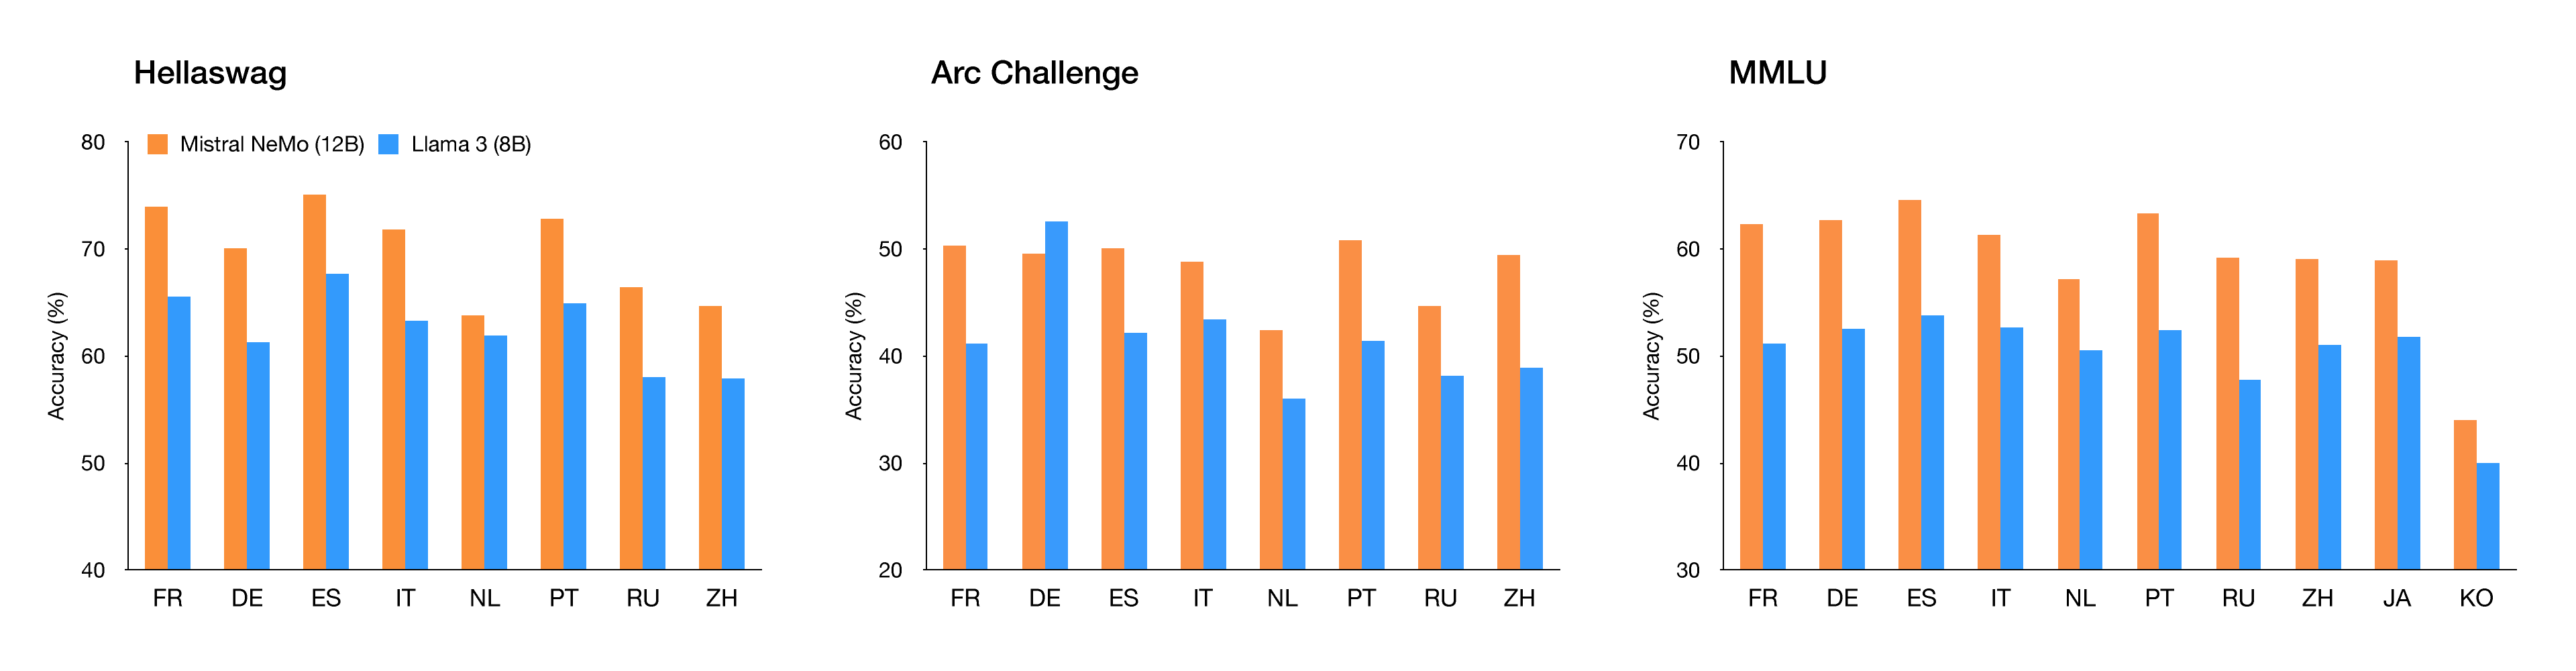

#### zero-shot

Техника промпт-инжиниринга, в которой мы, не давая модели никакой вспомогательной информации, ожидаем от нее ответа на запрос (промпт) в свободной форме.

In [225]:
from huggingface_hub import InferenceClient

client = InferenceClient(api_key="")  # ваш токен с  HuggingFace

Базово запустим модель через serverless API, предоставляемый HuggingFace. Это самый простой способо интегрировать модель в колаб. Для использования в реальных приложениях он не подойдет.

In [226]:
messages = [
	{
		"role": "user",
		"content": """Ты – преподаватель в университете.
                  Перечисли темы и разделы для дисциплины 'Язык Python для анализа данных'.
                  Разделов должно быть не более 8."""
	}
]

completion = client.chat.completions.create(
    model="mistralai/Mistral-Nemo-Instruct-2407",
	  messages=messages,
	  max_tokens=500
)

print(completion.choices[0].message.content)

Конечно, вот темы и разделы, которые можно включить в дисциплину "Язык Python для анализа данных" с целью соответствияifiéesства ровно 8 разделам:

1. Введение в Python и его использование для анализа данных
    * Основные концепции Python и среда выполнения Jupyter Notebooks
    * Установка и настройка Python, а также ключевых библиотек, таких как NumPy, Pandas и Matplotlib
2. Основы программирования на Python
    * Синтаксические конструкции, переменные, типы данных, операторы и управления потоком выполнения программы
    * Функции и модули
    * Структуры данных: списки, словари, множества и кортежи
    *Работа с файлами: чтение и запись в форматах CSV, TXT, JSON и т.д.
3. Модули NumPy и Pandas для работы с данными
    * Введение в NumPy: массивы, арифметические операции, работа с Сонпью-точными числами
    * Введение в Pandas: series, dataframes, индексы, ovalдиции данных и манипуляции с данными
4. Визуализация данных с помощью Matplotlib и Seaborn
    * Основы Matplotlib: рисовани

Можно получить что-то адекватное, а можно – что-то такое🤣

>**Текст промпта имеет значение!**

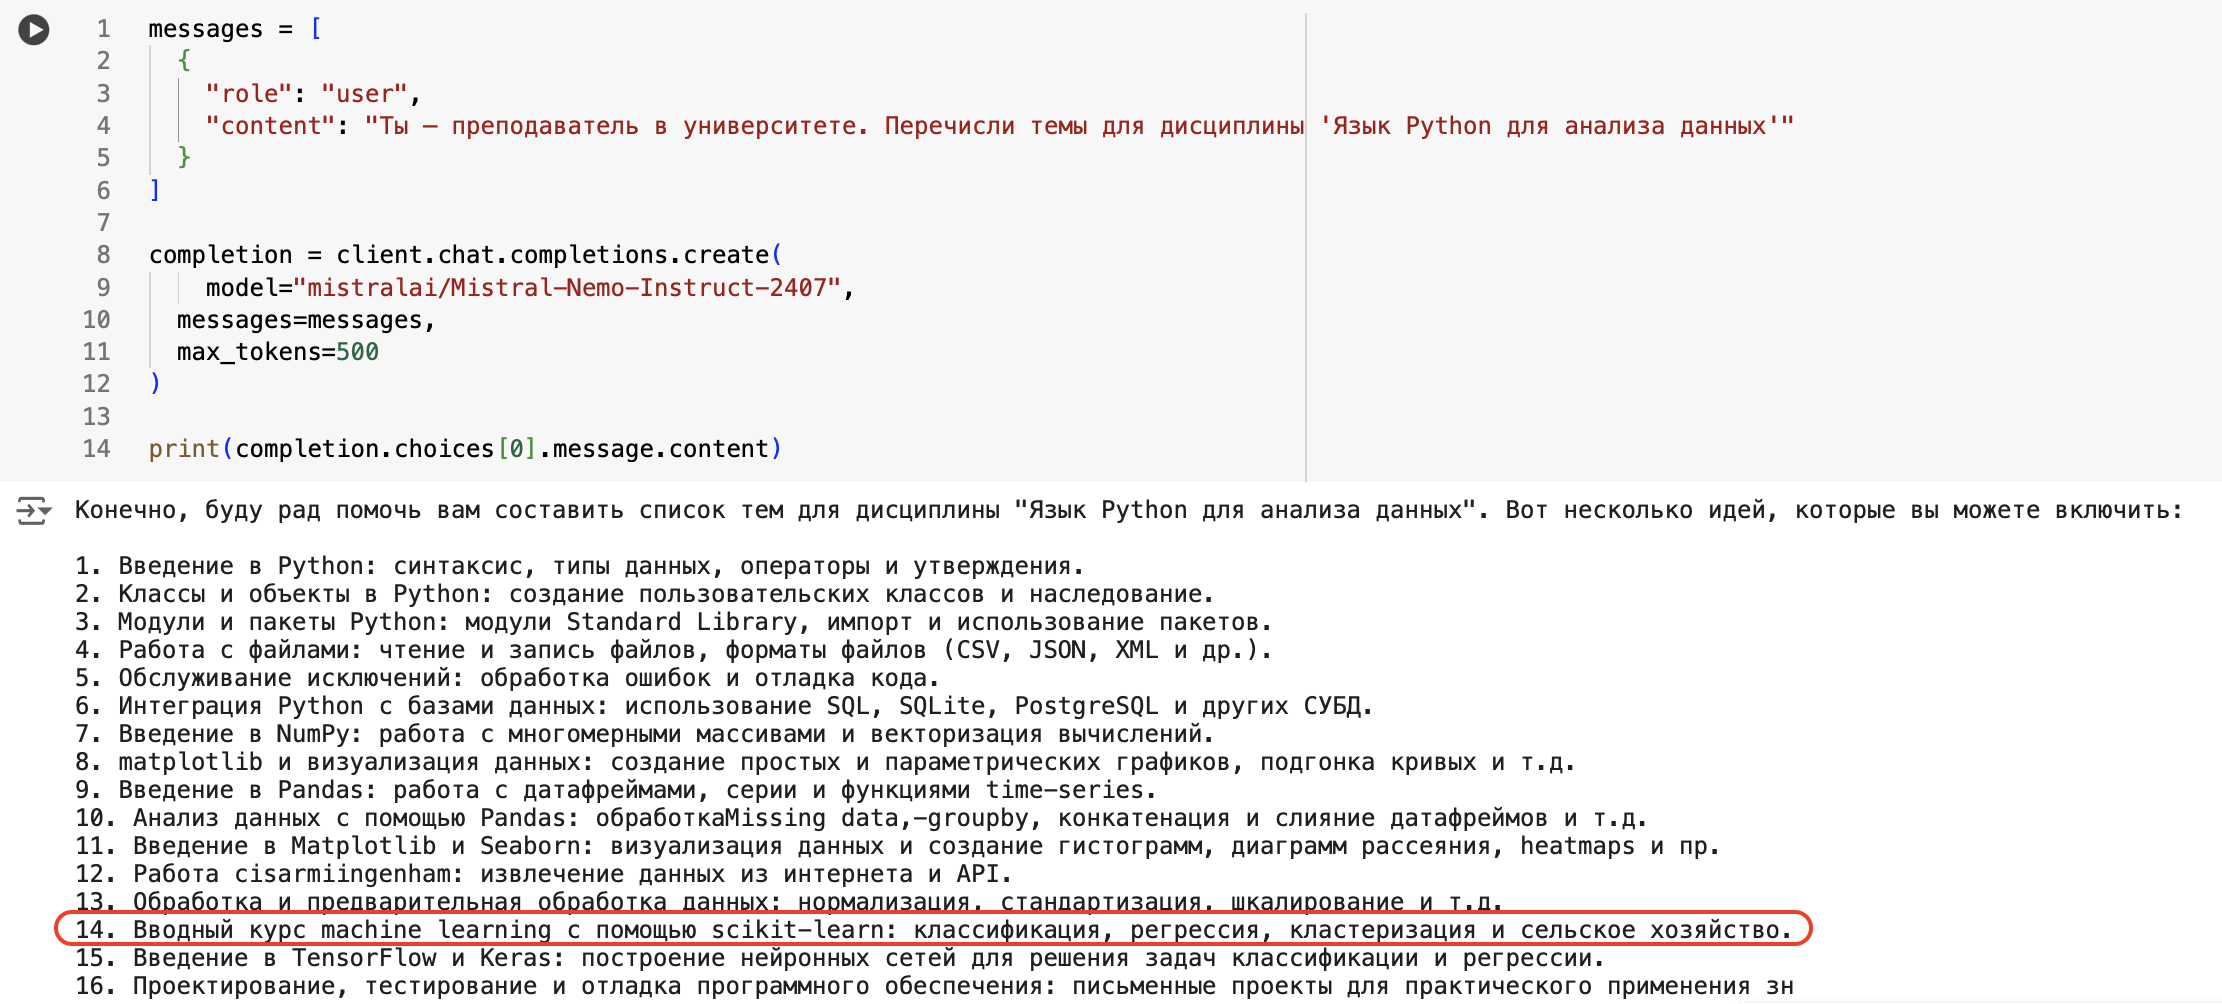

Но параметры API-запросов можно настраивать – https://huggingface.co/docs/api-inference/tasks/chat-completion

Наиболее ценные из них, сокращающие число галлюцинаций модели:
- temperature (температура): варьируется от 0 до 2 – чем выше, тем выше свобода модели в самовыражении и тем случайнее результат. До 0.5 считается низкой, но хорошо поэкспериментировать, чтобы подобрать наиболее адекватный для своей задачи результат.
- top_p – задает планку (долю), по которой отсекаются наименее релевантные ответы для вопроса, 0.1 означает, что для формирования ответа берутся 10% наиболее значимых токенов. Рекомендуется настраивать либо температуру, либо вероятность.

Поработаем с температурой. В качестве примера сгенерируем содержание дисциплины "Язык Python для анализа данных" с температурой от 0 до 2 с шагом 0.1.

In [150]:
import numpy as np

messages = [
	{
		"role": "user",
		"content": "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины 'Язык Python для анализа данных'. Разделов должно быть не более 8."
	}
]

temperatures = np.arange(0,2,0.1)

for temp in temperatures:
    print(f"\n{'*'*20} temperature = {temp} {'*'*20}\n")

    completion = client.chat.completions.create(
        model="mistralai/Mistral-Nemo-Instruct-2407",
        messages=messages,
        max_tokens=500,
        temperature=temp
    )

    print(completion.choices[0].message.content)



******************** temperature = 0.0 ********************

1. Введение в Python: основные понятия, синтаксис, типы данных, переменные, операторы, циклы, функции.
2. Модули и пакеты: импорт модулей, работа с пакетами, виртуальные окружения.
3. Работа с файлами: чтение и запись файлов, работа с директориями, исключения при работе с файлами.
4. Коллекции данных: списки, кортежи, словари, множества, работа с коллекциями.
5. Функции высшего порядка: map, filter, reduce, lambda-функции, декораторы.
6. Объектно-ориентированное программирование: классы, объекты, наследование, полиморфизм, инкапсуляция.
7. Работа с датами и временем: модуль datetime, форматирование дат и времени.
8. Введение в NumPy и Pandas: работа с многомерными массивами, сериалами, датафреймами, визуализация данных.

******************** temperature = 0.1 ********************

1. Введение в Python: основные понятия, синтаксис, типы данных, переменные, операторы, циклы, функции.
2. Модули и пакеты: импорт модулей, работа 

Вывод: если температуру выкрутить на максимум, концентрация бреда зашкаливает, перемешиваются языки, генерируютя несуществующие слова; а если занулить, то ответ получается похожий на правду, но очень ограниченный и сухой.
>**Нужно искать такое значение температуры, при котором будет соблюдаться баланс между честностью и свободой творчества.**

В примере выше наиболее интересные результаты получились при температуре от 0.3 до 0.7. Результат на 0.7 наиболее творческий и обширный. В таком примере стоит потестировать несколько температур и повалидировать их генерации.

Попробуем еще пару примеров с другими дисциплинами.

In [151]:
import numpy as np

courses = ["Машинное обучение",
           "Современные инструменты для анализа данных",
           "Методы визуализации данных"]

messages = [
	[{
		"role": "user",
		"content": "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {}. Разделов должно быть не более 8.".format(course)
	}] for course in courses
]

print(messages)

# перебирать температуры выше 1 не будем, там все плохо
temperatures = np.arange(0.3,1,0.1)


for i, message in enumerate(messages):

    for temp in temperatures:
        print(f"\n{'*'*20} {courses[i]}: temperature = {temp} {'*'*20}\n")

        completion = client.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
        )

        print(completion.choices[0].message.content)

[[{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Машинное обучение. Разделов должно быть не более 8.'}], [{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Современные инструменты для анализа данных. Разделов должно быть не более 8.'}], [{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Методы визуализации данных. Разделов должно быть не более 8.'}]]

******************** Машинное обучение: temperature = 0.3 ********************

1. Введение в машинное обучение
2. Математические основы машинного обучения
3. Алгоритмы обучения с учителем
4. Алгоритмы обучения без учителя
5. Нейронные сети и глубокое обучение
6. Выбор и оценка моделей
7. Применение машинного обучения в различных областях
8. Этические аспекты и безопасность в машинном обучении

******************** Машинное обучение: temperature = 0.4 ********************

1. 

Здесь наиболее интересные ответы получаются при температуре 0.5–0.7. 0.7 ни в одном примере пока не ушли в откровенные галлюцинации.

Теперь сгенерируем содержание для 100 случайных дисциплин. Не будем брать все с целью экономии времени. Если есть время и желание, можно для всех 1757.

In [227]:
ud = df[["course_title"]].drop_duplicates().sample(100, random_state=42)
ud.shape

(100, 1)

Напишите функцию `mistral_zero_shot()`, которая принимает на вход название дисциплины, объект клиента и значение температуры, а возвращает содержание дисциплины.

Альтернативно промпт можно тоже сделать параметром.

In [228]:
def mistral_zero_shot(course, cli, temp):
  message = [
    {"role": "user",
    "content": "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {}. Разделов должно быть не более 8.".format(course)
  }]
  completion = cli.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
            )
  return completion.choices[0].message.content

Добавьте столбец со сгенерированным содержанием в датафрейм.

In [229]:
generated_content =  [mistral_zero_shot(course, client, temp=0.5) for course in ud["course_title"]]
ud_df = df.reindex(ud.index)
ud_df['content_zero_shot'] = generated_content

In [230]:
# пример результата после добавления столбца с генерацией
print(ud_df.shape)
ud_df.sample(3, random_state=42)

(100, 20)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_clean,description_clean,contents_embed,description_embed,desc_cont_sim,contents_clean_joined,description_clean_joined,contents_bert_embedding,description_bert_embedding,desc_cont_sim_bert,content_zero_shot
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...","[дисциплина, обучающийся, быть, знать, междуна...","[-0.10309048, -0.18482833, -0.304068, 0.521679...","[-0.51130825, 0.13351278, -0.043703962, 0.0858...",0.848896,международный опыт экологический менеджмент ау...,дисциплина обучающийся быть знать международны...,"[0.04514328, 0.02981358, -0.0043485546, -0.038...","[0.07949328, -0.013909982, 0.020770341, -0.040...",0.914007,1. Введение в экологическое аудирование: понят...
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...","[цель, дисципин, сформировывать, обучающийся, ...","[0.17032494, 0.31813884, -1.2144904, 0.6403478...","[-0.23441674, -0.5601525, 0.4260293, 0.1455902...",0.373570,научный основа производство солнечный ветряной...,цель дисципин сформировывать обучающийся знани...,"[0.03630762, 0.003656776, 0.0026472383, -0.022...","[-0.016435474, -0.05178493, 0.033004783, -0.03...",0.797460,1. Введение в альтернативные источники энергии...
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...","[изучение, дисциплина, позволять, рассматриват...","[-0.008107593, -1.1964384, 0.113683775, 0.3836...","[-0.40391183, -0.79963744, 0.4093401, 0.528613...",0.785880,статистический метод контроль статистический м...,изучение дисциплина позволять рассматривать пе...,"[0.052147426, -0.015938062, -0.0038406083, -0....","[0.0030639062, -0.0060558254, 0.0018198256, -0...",0.878809,1. Введение в статистические методы контроля и...


Векторизуйте сгенерированное содержание с помощью обоих векторайзеров из предыдущего задания.

In [231]:
ud_df["content_zero_shot_clean"] = ud_df["content_zero_shot"].apply(clean_text)
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_clean,...,contents_embed,description_embed,desc_cont_sim,contents_clean_joined,description_clean_joined,contents_bert_embedding,description_bert_embedding,desc_cont_sim_bert,content_zero_shot,content_zero_shot_clean
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...",...,"[-0.10309048, -0.18482833, -0.304068, 0.521679...","[-0.51130825, 0.13351278, -0.043703962, 0.0858...",0.848896,международный опыт экологический менеджмент ау...,дисциплина обучающийся быть знать международны...,"[0.04514328, 0.02981358, -0.0043485546, -0.038...","[0.07949328, -0.013909982, 0.020770341, -0.040...",0.914007,1. Введение в экологическое аудирование: понят...,"[введение, экологический, аудирование, понятие..."
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...",...,"[0.17032494, 0.31813884, -1.2144904, 0.6403478...","[-0.23441674, -0.5601525, 0.4260293, 0.1455902...",0.373570,научный основа производство солнечный ветряной...,цель дисципин сформировывать обучающийся знани...,"[0.03630762, 0.003656776, 0.0026472383, -0.022...","[-0.016435474, -0.05178493, 0.033004783, -0.03...",0.797460,1. Введение в альтернативные источники энергии...,"[введение, альтернативный, источник, энергия, ..."
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...",...,"[-0.008107593, -1.1964384, 0.113683775, 0.3836...","[-0.40391183, -0.79963744, 0.4093401, 0.528613...",0.785880,статистический метод контроль статистический м...,изучение дисциплина позволять рассматривать пе...,"[0.052147426, -0.015938062, -0.0038406083, -0....","[0.0030639062, -0.0060558254, 0.0018198256, -0...",0.878809,1. Введение в статистические методы контроля и...,"[введение, статистический, метод, контроль, уп..."


In [232]:
ud_df['content_zero_shot_embed'] = ud_df['content_zero_shot_clean'].apply(lambda tokens: embed(tokens, w2v_model))
ud_df['content_zero_shot_clean_joined']=ud_df['content_zero_shot_clean'].apply(combine_tokens)
ud_df['content_zero_shot_bert_embedding'] = ud_df['content_zero_shot_clean_joined'].progress_apply(lambda x: bert_model.encode(x))

  0%|          | 0/100 [00:00<?, ?it/s]

In [233]:
# пример результата обработки
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_clean,...,contents_clean_joined,description_clean_joined,contents_bert_embedding,description_bert_embedding,desc_cont_sim_bert,content_zero_shot,content_zero_shot_clean,content_zero_shot_embed,content_zero_shot_clean_joined,content_zero_shot_bert_embedding
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...",...,международный опыт экологический менеджмент ау...,дисциплина обучающийся быть знать международны...,"[0.04514328, 0.02981358, -0.0043485546, -0.038...","[0.07949328, -0.013909982, 0.020770341, -0.040...",0.914007,1. Введение в экологическое аудирование: понят...,"[введение, экологический, аудирование, понятие...","[-0.19771358, -0.21445552, -0.5216579, 0.67163...",введение экологический аудирование понятие цел...,"[0.03384187, -0.028534077, 0.049673885, -0.000..."
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...",...,научный основа производство солнечный ветряной...,цель дисципин сформировывать обучающийся знани...,"[0.03630762, 0.003656776, 0.0026472383, -0.022...","[-0.016435474, -0.05178493, 0.033004783, -0.03...",0.797460,1. Введение в альтернативные источники энергии...,"[введение, альтернативный, источник, энергия, ...","[-0.08475172, -0.076970935, -0.7581819, 0.4938...",введение альтернативный источник энергия аиэ о...,"[0.022492303, -0.0013481292, 0.046173777, -0.0..."
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...",...,статистический метод контроль статистический м...,изучение дисциплина позволять рассматривать пе...,"[0.052147426, -0.015938062, -0.0038406083, -0....","[0.0030639062, -0.0060558254, 0.0018198256, -0...",0.878809,1. Введение в статистические методы контроля и...,"[введение, статистический, метод, контроль, уп...","[-0.4696647, -1.9272145, 0.6467926, 1.5972824,...",введение статистический метод контроль управле...,"[0.016882904, -0.013499309, 0.013402285, -0.01..."


Посчитайте косинусное сходство вектора исходных содержаний и сгенерированных для обоих векторайзеров.

In [234]:
ud_df["desc_content_zero_shot"] = ud_df.apply(lambda x: cosine_similarity(x["contents_embed"], x["content_zero_shot_embed"]), axis=1)
ud_df["desc_content_zero_shot_bert"] = ud_df.apply(lambda x: cosine_similarity(x["contents_bert_embedding"], x["content_zero_shot_bert_embedding"]), axis=1)

In [235]:
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_clean,...,contents_bert_embedding,description_bert_embedding,desc_cont_sim_bert,content_zero_shot,content_zero_shot_clean,content_zero_shot_embed,content_zero_shot_clean_joined,content_zero_shot_bert_embedding,desc_content_zero_shot,desc_content_zero_shot_bert
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...",...,"[0.04514328, 0.02981358, -0.0043485546, -0.038...","[0.07949328, -0.013909982, 0.020770341, -0.040...",0.914007,1. Введение в экологическое аудирование: понят...,"[введение, экологический, аудирование, понятие...","[-0.19771358, -0.21445552, -0.5216579, 0.67163...",введение экологический аудирование понятие цел...,"[0.03384187, -0.028534077, 0.049673885, -0.000...",0.890153,0.885697
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...",...,"[0.03630762, 0.003656776, 0.0026472383, -0.022...","[-0.016435474, -0.05178493, 0.033004783, -0.03...",0.797460,1. Введение в альтернативные источники энергии...,"[введение, альтернативный, источник, энергия, ...","[-0.08475172, -0.076970935, -0.7581819, 0.4938...",введение альтернативный источник энергия аиэ о...,"[0.022492303, -0.0013481292, 0.046173777, -0.0...",0.837742,0.918554
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...",...,"[0.052147426, -0.015938062, -0.0038406083, -0....","[0.0030639062, -0.0060558254, 0.0018198256, -0...",0.878809,1. Введение в статистические методы контроля и...,"[введение, статистический, метод, контроль, уп...","[-0.4696647, -1.9272145, 0.6467926, 1.5972824,...",введение статистический метод контроль управле...,"[0.016882904, -0.013499309, 0.013402285, -0.01...",0.860254,0.907776



Повторите этот пайплайн для генерации краткого описания дисциплины (`description`) в технике `zero-shot`.

In [236]:
def mistral_zero_shot_description(course, cli, temp):
  message = [
    {"role": "user",
    "content": "Ты – преподаватель в университете. Напиши краткое описание дисциплины для дисциплины {}.".format(course)
  }]
  completion = cli.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
            )
  return completion.choices[0].message.content

In [237]:
generated_content =  [mistral_zero_shot_description(course, client, temp=0.6) for course in ud["course_title"]]
ud_df['description_zero_shot'] = generated_content
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_clean,...,description_bert_embedding,desc_cont_sim_bert,content_zero_shot,content_zero_shot_clean,content_zero_shot_embed,content_zero_shot_clean_joined,content_zero_shot_bert_embedding,desc_content_zero_shot,desc_content_zero_shot_bert,description_zero_shot
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...",...,"[0.07949328, -0.013909982, 0.020770341, -0.040...",0.914007,1. Введение в экологическое аудирование: понят...,"[введение, экологический, аудирование, понятие...","[-0.19771358, -0.21445552, -0.5216579, 0.67163...",введение экологический аудирование понятие цел...,"[0.03384187, -0.028534077, 0.049673885, -0.000...",0.890153,0.885697,Экологическое аудирование является дисциплиной...
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...",...,"[-0.016435474, -0.05178493, 0.033004783, -0.03...",0.797460,1. Введение в альтернативные источники энергии...,"[введение, альтернативный, источник, энергия, ...","[-0.08475172, -0.076970935, -0.7581819, 0.4938...",введение альтернативный источник энергия аиэ о...,"[0.022492303, -0.0013481292, 0.046173777, -0.0...",0.837742,0.918554,"Дисциплина ""Исследование альтернативных источн..."
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...",...,"[0.0030639062, -0.0060558254, 0.0018198256, -0...",0.878809,1. Введение в статистические методы контроля и...,"[введение, статистический, метод, контроль, уп...","[-0.4696647, -1.9272145, 0.6467926, 1.5972824,...",введение статистический метод контроль управле...,"[0.016882904, -0.013499309, 0.013402285, -0.01...",0.860254,0.907776,"Дисциплина ""Статистические методы контроля и у..."


In [238]:
ud_df["description_zero_shot_clean"] = ud_df["description_zero_shot"].apply(clean_text)
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_clean,...,desc_cont_sim_bert,content_zero_shot,content_zero_shot_clean,content_zero_shot_embed,content_zero_shot_clean_joined,content_zero_shot_bert_embedding,desc_content_zero_shot,desc_content_zero_shot_bert,description_zero_shot,description_zero_shot_clean
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...",...,0.914007,1. Введение в экологическое аудирование: понят...,"[введение, экологический, аудирование, понятие...","[-0.19771358, -0.21445552, -0.5216579, 0.67163...",введение экологический аудирование понятие цел...,"[0.03384187, -0.028534077, 0.049673885, -0.000...",0.890153,0.885697,Экологическое аудирование является дисциплиной...,"[экологический, аудирование, являться, дисципл..."
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...",...,0.797460,1. Введение в альтернативные источники энергии...,"[введение, альтернативный, источник, энергия, ...","[-0.08475172, -0.076970935, -0.7581819, 0.4938...",введение альтернативный источник энергия аиэ о...,"[0.022492303, -0.0013481292, 0.046173777, -0.0...",0.837742,0.918554,"Дисциплина ""Исследование альтернативных источн...","[дисциплина, исследование, альтернативный, ист..."
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...",...,0.878809,1. Введение в статистические методы контроля и...,"[введение, статистический, метод, контроль, уп...","[-0.4696647, -1.9272145, 0.6467926, 1.5972824,...",введение статистический метод контроль управле...,"[0.016882904, -0.013499309, 0.013402285, -0.01...",0.860254,0.907776,"Дисциплина ""Статистические методы контроля и у...","[дисциплина, статистический, метод, контроль, ..."


In [239]:
ud_df['description_zero_shot_embed'] = ud_df['description_zero_shot_clean'].apply(lambda tokens: embed(tokens, w2v_model))
ud_df['description_zero_shot_clean_joined']=ud_df['description_zero_shot_clean'].apply(combine_tokens)
ud_df['description_zero_shot_bert_embedding'] = ud_df['description_zero_shot_clean_joined'].progress_apply(lambda x: bert_model.encode(x))

  0%|          | 0/100 [00:00<?, ?it/s]

In [240]:
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_clean,...,content_zero_shot_embed,content_zero_shot_clean_joined,content_zero_shot_bert_embedding,desc_content_zero_shot,desc_content_zero_shot_bert,description_zero_shot,description_zero_shot_clean,description_zero_shot_embed,description_zero_shot_clean_joined,description_zero_shot_bert_embedding
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...",...,"[-0.19771358, -0.21445552, -0.5216579, 0.67163...",введение экологический аудирование понятие цел...,"[0.03384187, -0.028534077, 0.049673885, -0.000...",0.890153,0.885697,Экологическое аудирование является дисциплиной...,"[экологический, аудирование, являться, дисципл...","[-0.20030437, -0.45646116, 0.49732566, 0.59812...",экологический аудирование являться дисциплина ...,"[0.060116075, -0.01466874, 0.016143456, -0.036..."
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...",...,"[-0.08475172, -0.076970935, -0.7581819, 0.4938...",введение альтернативный источник энергия аиэ о...,"[0.022492303, -0.0013481292, 0.046173777, -0.0...",0.837742,0.918554,"Дисциплина ""Исследование альтернативных источн...","[дисциплина, исследование, альтернативный, ист...","[-0.27914092, -0.41327077, 0.11964975, 0.81614...",дисциплина исследование альтернативный источни...,"[0.0117367925, -0.019133773, 0.05434694, -0.05..."
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...",...,"[-0.4696647, -1.9272145, 0.6467926, 1.5972824,...",введение статистический метод контроль управле...,"[0.016882904, -0.013499309, 0.013402285, -0.01...",0.860254,0.907776,"Дисциплина ""Статистические методы контроля и у...","[дисциплина, статистический, метод, контроль, ...","[-0.5493743, -1.2325591, 0.7439944, 1.1655195,...",дисциплина статистический метод контроль управ...,"[0.035244685, -0.0097294105, 0.0030974948, -0...."


In [241]:
ud_df["desc_description_zero_shot"] = ud_df.apply(lambda x: cosine_similarity(x["description_embed"], x["description_zero_shot_embed"]), axis=1)
ud_df["desc_description_zero_shot_bert"] = ud_df.apply(lambda x: cosine_similarity(x["description_bert_embedding"], x["description_zero_shot_bert_embedding"]), axis=1)

In [242]:
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_clean,...,content_zero_shot_bert_embedding,desc_content_zero_shot,desc_content_zero_shot_bert,description_zero_shot,description_zero_shot_clean,description_zero_shot_embed,description_zero_shot_clean_joined,description_zero_shot_bert_embedding,desc_description_zero_shot,desc_description_zero_shot_bert
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...",...,"[0.03384187, -0.028534077, 0.049673885, -0.000...",0.890153,0.885697,Экологическое аудирование является дисциплиной...,"[экологический, аудирование, являться, дисципл...","[-0.20030437, -0.45646116, 0.49732566, 0.59812...",экологический аудирование являться дисциплина ...,"[0.060116075, -0.01466874, 0.016143456, -0.036...",0.807306,0.917657
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...",...,"[0.022492303, -0.0013481292, 0.046173777, -0.0...",0.837742,0.918554,"Дисциплина ""Исследование альтернативных источн...","[дисциплина, исследование, альтернативный, ист...","[-0.27914092, -0.41327077, 0.11964975, 0.81614...",дисциплина исследование альтернативный источни...,"[0.0117367925, -0.019133773, 0.05434694, -0.05...",0.834126,0.914002
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...",...,"[0.016882904, -0.013499309, 0.013402285, -0.01...",0.860254,0.907776,"Дисциплина ""Статистические методы контроля и у...","[дисциплина, статистический, метод, контроль, ...","[-0.5493743, -1.2325591, 0.7439944, 1.1655195,...",дисциплина статистический метод контроль управ...,"[0.035244685, -0.0097294105, 0.0030974948, -0....",0.794867,0.892539


#### few-shot

Как следует из названия техники, few-shot подразумевает, что мы даем модели несколько примеров, по которым она должна понять, в каком формате (и/или какого рода информацию) мы ожидаем получить в ответ на запрос. Эти примеры подаются как часть промпта. Можно также встретить понятия one-shot (один пример), two-shot (два примера) и т.д. Это частные случаи few-shot.

Попробуем развить предыдущий пример, используя как эталонный вариант ответа результат при температуре 0.7 для дисциплины "Язык Python для анализа данных".

In [168]:
import numpy as np

courses = ["Машинное обучение",
           "Современные инструменты для анализа данных",
           "Методы визуализации данных"]

messages = [
	[{
		"role": "user",
		"content": """Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Язык Python для анализа данных. Разделов должно быть не более 8.
Ответ:
   Тема 1: Введение в Python для анализа данных
- Обзор Python и его применения в анализе данных
- Установка и настройка Python и основных библиотек (NumPy, Pandas, Matplotlib, etc.)
- Основы синтаксиса Python

Тема 2: Основы анализа данных
- Типы данных и структуры данных в Python
- Обработка и очистка данных
- Работа с большими данными

Тема 3: Анализ данных с помощью NumPy
- Введение в NumPy
- Массивы и векторы
- Операции над массивами
- Функции и методы NumPy

Тема 4: Анализ данных с помощью Pandas
- Введение в Pandas
- Сериалы и ДатаФреймы
- Обработка и манипулирование данными
- Агрегация и групповые операции

Тема 5: Визуализация данных с помощью Matplotlib и Seaborn
- Введение в Matplotlib
- Создание простых графиков
- Настройка стиля и темы
- Введение в Seaborn

Тема 6: Статистический анализ данных
- Введение в статистический анализ
- Работа с вероятностями и распределениями
- Основные статистические тесты

Тема 7: Машинное обучение и анализ данных
- Введение в машинное обучение
- Классификация и регрессия
- Искусственные нейронные сети

Тема 8: Проекты и применение знаний
- Создание проектов по анализу данных
- Презентация результатов анализа
- Обсуждение практического применения знаний в реальных ситуациях

Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {}. Разделов должно быть не более 8."""
.format(course)
	}] for course in courses
]

print(messages)

# перебирать температуры выше 1 не будем, там все плохо
temperatures = np.arange(0.3,0.8,0.1)


for i, message in enumerate(messages):

    for temp in temperatures:
        print(f"\n{'*'*20} {courses[i]}: temperature = {temp} {'*'*20}\n")

        completion = client.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
        )

        print(completion.choices[0].message.content)

[[{'role': 'user', 'content': 'Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Язык Python для анализа данных. Разделов должно быть не более 8.\nОтвет:\n   Тема 1: Введение в Python для анализа данных\n- Обзор Python и его применения в анализе данных\n- Установка и настройка Python и основных библиотек (NumPy, Pandas, Matplotlib, etc.)\n- Основы синтаксиса Python\n\nТема 2: Основы анализа данных\n- Типы данных и структуры данных в Python\n- Обработка и очистка данных\n- Работа с большими данными\n\nТема 3: Анализ данных с помощью NumPy\n- Введение в NumPy\n- Массивы и векторы\n- Операции над массивами\n- Функции и методы NumPy\n\nТема 4: Анализ данных с помощью Pandas\n- Введение в Pandas\n- Сериалы и ДатаФреймы\n- Обработка и манипулирование данными\n- Агрегация и групповые операции\n\nТема 5: Визуализация данных с помощью Matplotlib и Seaborn\n- Введение в Matplotlib\n- Создание простых графиков\n- Настройка стиля и темы\n- Введение в Seaborn\n\nТем

Если показывать модели пример запроса и эталонный ответ, то наиболее близкие к правде ответы получаются при самых низких температурах. Возможно, ниже 0.3 было бы еще грамотнее. Зато при более высоких модели не хватает токенов и появляется много подробностей, которые, возможно, излишни.

Напишите функцию `mistral_one_shot()`, которая принимает на вход название дисциплины, объект клиента и значение температуры, а возвращает содержание дисциплины.

Аналогично предыдущему разделу, сгенерируйте содержание для выбранных 100 дисциплин (или всех). Затем предобработайте данные и проведите векторизацию обоими векторайзерами.

In [243]:
def mistral_one_shot(course, cli, temp):
    messages =[{
          "role": "user",
          "content": """Запрос: Перечисли темы и разделы для дисциплины Проектирование и реализация баз данных.
          Ответ: Концепция баз данных
          Этапы и методологии проектирования систем и баз данных
          Современными Case-средства проектирования информационных систем и баз данных
          Навыки обследования предметной области
          Построение функциональной модели АИС
          Построение инфологической и логической моделей БД
          Работа в реляционной СУБД и NoSQL СУБД
          Навыки работы с декларативным языком SQL для описания и манипулирования реляционными данными,
          Написание процедур, функций и триггеров в SQL,
          Первичные навыки разработки интерфейсов для выполнения CRUD-операций над базой данных средствами PHP

          Запрос: Перечисли темы и разделы для дисциплины {}.""" .format(course)
          }]


    completion = cli.chat.completions.create(
        model="mistralai/Mistral-Nemo-Instruct-2407",
        messages=message,
        max_tokens=500,
        temperature=temp
    )

    return completion.choices[0].message.content


In [244]:
ud_df['content_one_shot'] = [mistral_one_shot(course, client, temp=0.5) for course in ud["course_title"]]

In [245]:
ud_df["content_one_shot_clean"] = ud_df["content_one_shot"].apply(clean_text)

In [246]:
ud_df['content_one_shot_embed'] = ud_df['content_one_shot_clean'].apply(lambda tokens: embed(tokens, w2v_model))
ud_df['content_one_shot_clean_joined']=ud_df['content_one_shot_clean'].apply(combine_tokens)
ud_df['content_one_shot_bert_embedding'] = ud_df['content_one_shot_clean_joined'].progress_apply(lambda x: bert_model.encode(x))

  0%|          | 0/100 [00:00<?, ?it/s]

In [247]:
ud_df["desc_content_one_shot"] = ud_df.apply(lambda x: cosine_similarity(x["contents_embed"], x["content_one_shot_embed"]), axis=1)
ud_df["desc_content_one_shot_bert"] = ud_df.apply(lambda x: cosine_similarity(x["contents_bert_embedding"], x["content_one_shot_bert_embedding"]), axis=1)

In [248]:
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_clean,...,description_zero_shot_bert_embedding,desc_description_zero_shot,desc_description_zero_shot_bert,content_one_shot,content_one_shot_clean,content_one_shot_embed,content_one_shot_clean_joined,content_one_shot_bert_embedding,desc_content_one_shot,desc_content_one_shot_bert
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...",...,"[0.060116075, -0.01466874, 0.016143456, -0.036...",0.807306,0.917657,Тема 1: Введение в визуализацию данных\n- Обзо...,"[тема, введение, визуализация, данный, обзор, ...","[-0.61081254, -0.50907063, 1.0355246, 0.614845...",тема введение визуализация данный обзор важнос...,"[-0.024779119, -0.0022217997, 0.04924292, -0.0...",0.211923,0.707344
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...",...,"[0.0117367925, -0.019133773, 0.05434694, -0.05...",0.834126,0.914002,Тема 1: Введение в визуализацию данных\n- Обзо...,"[тема, введение, визуализация, данный, обзор, ...","[-0.61081254, -0.50907063, 1.0355246, 0.614845...",тема введение визуализация данный обзор важнос...,"[-0.024779119, -0.0022217997, 0.04924292, -0.0...",0.075701,0.703794
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...",...,"[0.035244685, -0.0097294105, 0.0030974948, -0....",0.794867,0.892539,Тема 1: Введение в визуализацию данных\n- Обзо...,"[тема, введение, визуализация, данный, обзор, ...","[-0.61081254, -0.50907063, 1.0355246, 0.614845...",тема введение визуализация данный обзор важнос...,"[-0.024779119, -0.0022217997, 0.04924292, -0.0...",0.573058,0.744286



Повторите этот пайплайн для генерации краткого описания дисциплины (`description`) в технике `few-shot`.

In [249]:
def mistral_one_shot_description(course, cli, temp):
    messages =[{
          "role": "user",
          "content": """Запрос: Сгенерируй краткое описание для дисциплины Проектирование и реализация баз данных.
          Ответ: Дисциплина познакомит слушателей с концепцией баз данных, этапами и методологиями проектирования систем и баз данных,
          современными Case-средствами проектирования информационных систем и баз данных. Будут получены навыки обследования предметной
          области, построения функциональной модели АИС, инфологической и логической моделей БД, навыки работы.
          Слушатели освоят работу в реляционной СУБД и NoSQL СУБД, получат навыки работы с декларативным языком SQL для описания и
          манипулирования реляционными данными, использования индексов, написания процедур, функций и триггеров в SQL,
          освоят первичные навыки разработки интерфейсов для выполнения CRUD-операций над базой данных средствами PHP.

          Запрос: Сгенерируй краткое описание для дисциплины {}.""" .format(course)
          }]


    completion = cli.chat.completions.create(
        model="mistralai/Mistral-Nemo-Instruct-2407",
        messages=message,
        max_tokens=500,
        temperature=temp
    )

    return completion.choices[0].message.content

In [250]:
ud_df['description_one_shot'] = [mistral_one_shot(course, client, temp=0.5) for course in ud["course_title"]]

In [251]:
ud_df["description_one_shot_clean"] = ud_df["description_one_shot"].apply(clean_text)

In [252]:
ud_df['description_one_shot_embed'] = ud_df['description_one_shot_clean'].apply(lambda tokens: embed(tokens, w2v_model))
ud_df['description_one_shot_clean_joined']=ud_df['description_one_shot_clean'].apply(combine_tokens)
ud_df['description_one_shot_bert_embedding'] = ud_df['description_one_shot_clean_joined'].progress_apply(lambda x: bert_model.encode(x))

  0%|          | 0/100 [00:00<?, ?it/s]

In [253]:
ud_df["desc_description_one_shot"] = ud_df.apply(lambda x: cosine_similarity(x["description_embed"], x["description_one_shot_embed"]), axis=1)
ud_df["desc_description_one_shot_bert"] = ud_df.apply(lambda x: cosine_similarity(x["description_bert_embedding"], x["description_one_shot_bert_embedding"]), axis=1)

In [254]:
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_clean,...,content_one_shot_bert_embedding,desc_content_one_shot,desc_content_one_shot_bert,description_one_shot,description_one_shot_clean,description_one_shot_embed,description_one_shot_clean_joined,description_one_shot_bert_embedding,desc_description_one_shot,desc_description_one_shot_bert
4535,4475,Экологическое аудирование,После дисциплины обучающиеся будут знать - ме...,6917,Биотехнология,bachelor,2019,"Специализация ""Экобиотехнология""",Международный опыт экологического менеджмента ...,"[международный, опыт, экологический, менеджмен...",...,"[-0.024779119, -0.0022217997, 0.04924292, -0.0...",0.211923,0.707344,Тема 1: Введение в визуализацию данных\n- Обзо...,"[тема, введение, визуализация, данный, обзор, ...","[-0.61081254, -0.50907063, 1.0355246, 0.614845...",тема введение визуализация данный обзор важнос...,"[-0.024779119, -0.0022217997, 0.04924292, -0.0...",0.231092,0.708679
15251,15589,Исследование альтернативных источников энергии,Цель дисципины — сформировать у обучающихся зн...,7336,Индустриальная экология / Industrial ecology,master,2021,"Специализация ""Интегрированный менеджмент""",Научные основы производства солнечной и ветрян...,"[научный, основа, производство, солнечный, вет...",...,"[-0.024779119, -0.0022217997, 0.04924292, -0.0...",0.075701,0.703794,Тема 1: Введение в визуализацию данных\n- Обзо...,"[тема, введение, визуализация, данный, обзор, ...","[-0.61081254, -0.50907063, 1.0355246, 0.614845...",тема введение визуализация данный обзор важнос...,"[-0.024779119, -0.0022217997, 0.04924292, -0.0...",0.487511,0.777567
6110,4949,Статистические методы контроля и управления,Изучение дисциплины позволит рассмотреть персп...,6942,Управление качеством,master,2020,"Специализация ""Аудит и сертификация качества""",Статистические методы контроля. Статистически...,"[статистический, метод, контроль, статистическ...",...,"[-0.024779119, -0.0022217997, 0.04924292, -0.0...",0.573058,0.744286,Тема 1: Введение в визуализацию данных\n- Обзо...,"[тема, введение, визуализация, данный, обзор, ...","[-0.61081254, -0.50907063, 1.0355246, 0.614845...",тема введение визуализация данный обзор важнос...,"[-0.024779119, -0.0022217997, 0.04924292, -0.0...",0.469609,0.783848


## Задача 3 – Проанализировать результаты

Постройте визуализации для оценки результатов генерации искусственных данных по дисциплинам. В каждом пункте оценивайте результаты генерации в обеих техниках. Для каждого пункта напишите краткий вывод.

1. Постройте гистограмму, показывающую распределения сходств краткого описания с эталонным (человеческим) и содержания. Сравните результаты для обоих векторайзеров.

In [255]:
print(ud_df.columns)

Index(['course_id', 'course_title', 'description', 'up_id', 'up_title',
       'qualification', 'start_year', 'module_name', 'contents',
       'contents_clean', 'description_clean', 'contents_embed',
       'description_embed', 'desc_cont_sim', 'contents_clean_joined',
       'description_clean_joined', 'contents_bert_embedding',
       'description_bert_embedding', 'desc_cont_sim_bert', 'content_zero_shot',
       'content_zero_shot_clean', 'content_zero_shot_embed',
       'content_zero_shot_clean_joined', 'content_zero_shot_bert_embedding',
       'desc_content_zero_shot', 'desc_content_zero_shot_bert',
       'description_zero_shot', 'description_zero_shot_clean',
       'description_zero_shot_embed', 'description_zero_shot_clean_joined',
       'description_zero_shot_bert_embedding', 'desc_description_zero_shot',
       'desc_description_zero_shot_bert', 'content_one_shot',
       'content_one_shot_clean', 'content_one_shot_embed',
       'content_one_shot_clean_joined', 'content

In [264]:
def draw_hist(ax, title, column, color):
  sns.histplot(ud_df[column], bins=30, kde=True, color=color, ax=ax)
  plt.axvline(ud_df[column].median(), color="black", linestyle="--")
  plt.title(title)
  plt.legend()
  ax.grid(True)

<ipython-input-266-ad85f8e365e2>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
<ipython-input-266-ad85f8e365e2>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


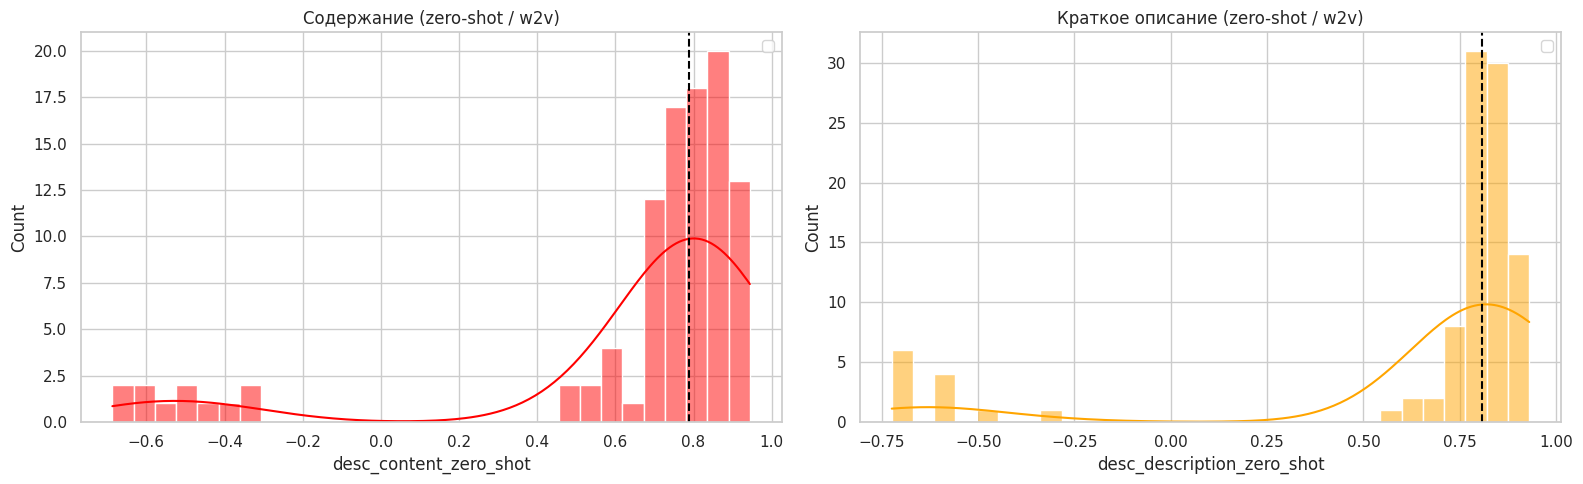

In [270]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
draw_hist(axes[0], "Содержание (zero-shot / w2v)", "desc_content_zero_shot", "red")
draw_hist(axes[1], "Краткое описание (zero-shot / w2v)", "desc_description_zero_shot", "orange")
plt.tight_layout()
plt.show()

<ipython-input-266-ad85f8e365e2>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
<ipython-input-266-ad85f8e365e2>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


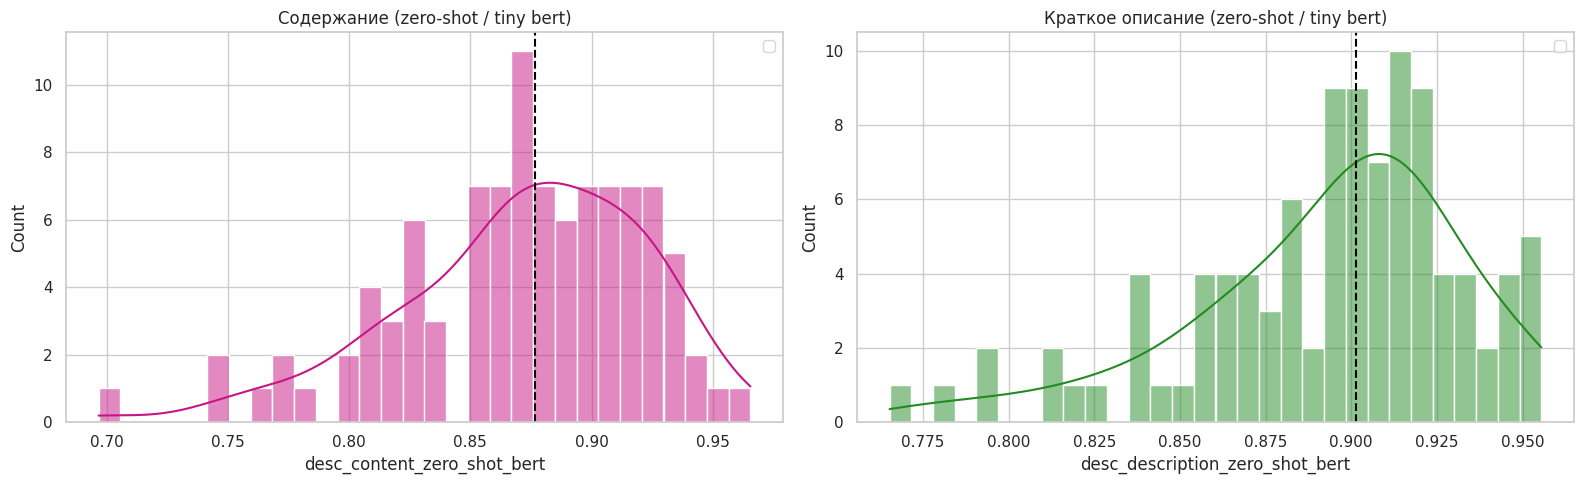

In [286]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
draw_hist(axes[0], "Содержание (zero-shot / tiny bert)", "desc_content_zero_shot_bert", "mediumvioletred")
draw_hist(axes[1], "Краткое описание (zero-shot / tiny bert)", "desc_description_zero_shot_bert", "forestgreen")
plt.tight_layout()
plt.show()

<ipython-input-266-ad85f8e365e2>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
<ipython-input-266-ad85f8e365e2>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


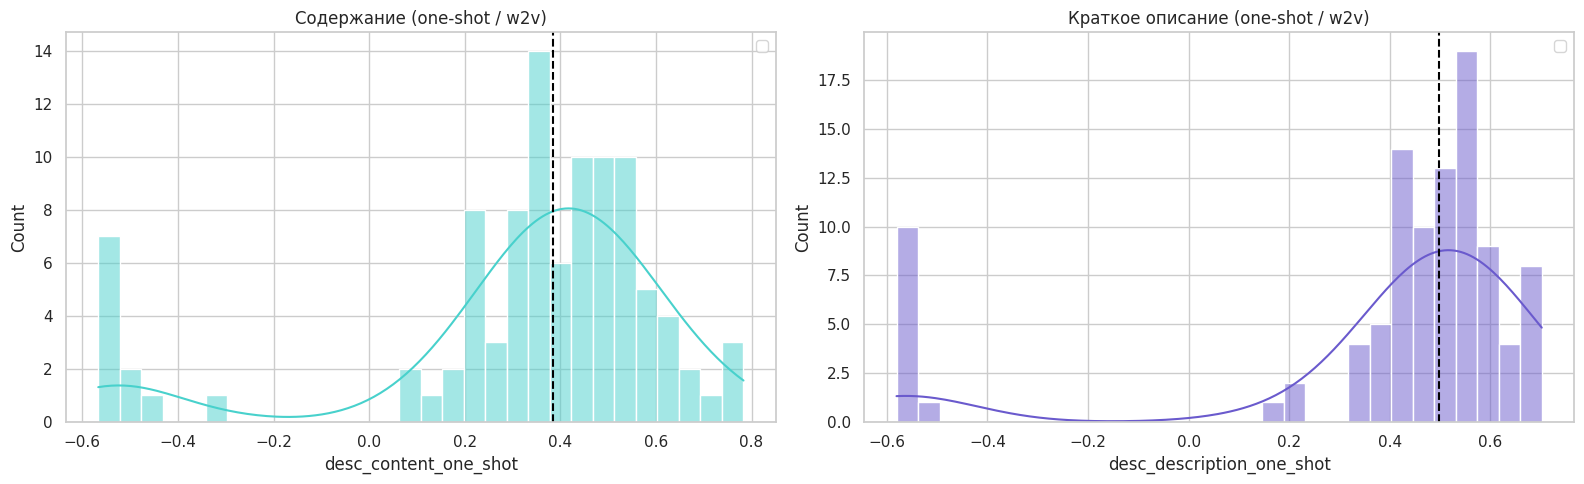

In [272]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
draw_hist(axes[0], "Содержание (one-shot / w2v)", "desc_content_one_shot", "mediumturquoise")
draw_hist(axes[1], "Краткое описание (one-shot / w2v)", "desc_description_one_shot", "slateblue")
plt.tight_layout()
plt.show()

<ipython-input-266-ad85f8e365e2>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
<ipython-input-266-ad85f8e365e2>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


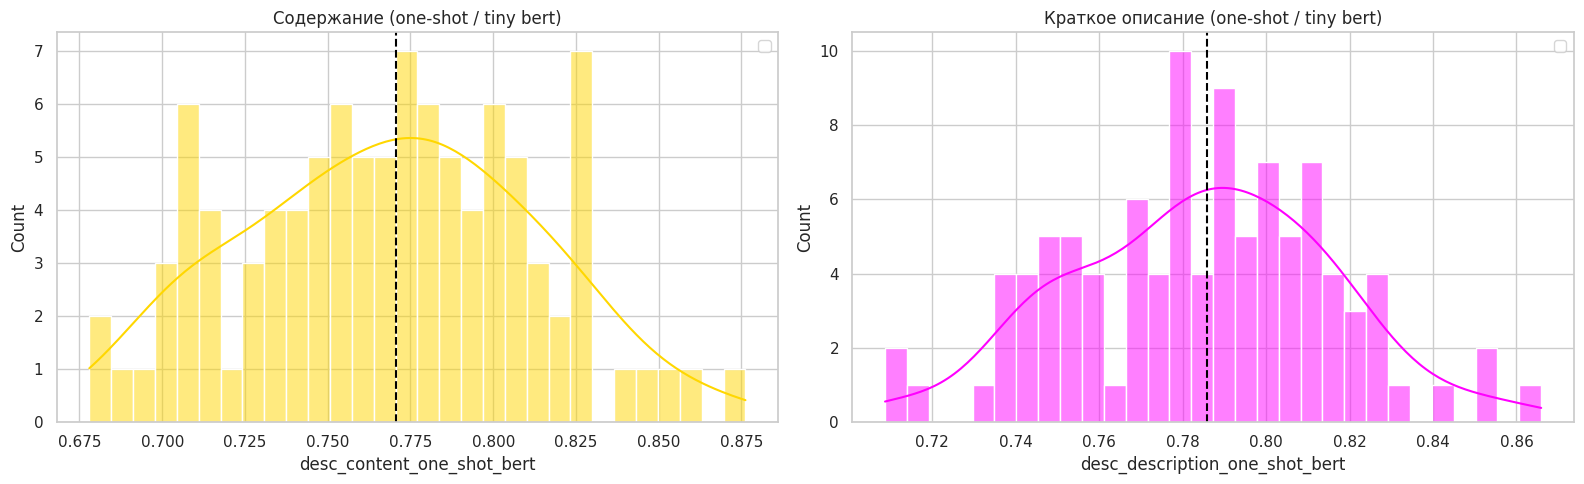

In [273]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
draw_hist(axes[0], "Содержание (one-shot / tiny bert)", "desc_content_one_shot_bert", "gold")
draw_hist(axes[1], "Краткое описание (one-shot / tiny bert)", "desc_description_one_shot_bert", "fuchsia")
plt.tight_layout()
plt.show()

Вывод: из графиков видно, что медиана косинусного сходства наилучшим образом и более стабильно проявляется на всех графиках zero-shot в сравнении с one-shot. У one-shot показатели не такие высокие и стабильные, в работе с различными типами векторизации они по-разному себя проявляют (например, для краткого описания one-shot совсем плохо работает с w2v).

2. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по уровням образования (`qualification`). Сравните результаты для обоих векторайзеров.

In [300]:
ud_df_qualification = ud_df.groupby("qualification").agg({
    "desc_content_zero_shot": "mean",
    "desc_content_zero_shot_bert": "mean",
    "desc_description_zero_shot": "mean",
    "desc_description_zero_shot_bert": "mean",
    "desc_content_one_shot": "mean",
    "desc_content_one_shot_bert": "mean",
    "desc_description_one_shot": "mean",
    "desc_description_one_shot_bert": "mean"
}).reset_index()

ud_df_qualification

,qualification,desc_content_zero_shot,desc_content_zero_shot_bert,desc_description_zero_shot,desc_description_zero_shot_bert,desc_content_one_shot,desc_content_one_shot_bert,desc_description_one_shot,desc_description_one_shot_bert
0,bachelor,0.765196,0.881528,0.767598,0.901608,0.370481,0.768198,0.474573,0.785719
1,master,0.480466,0.858729,0.481082,0.881858,0.251162,0.769035,0.277735,0.782221


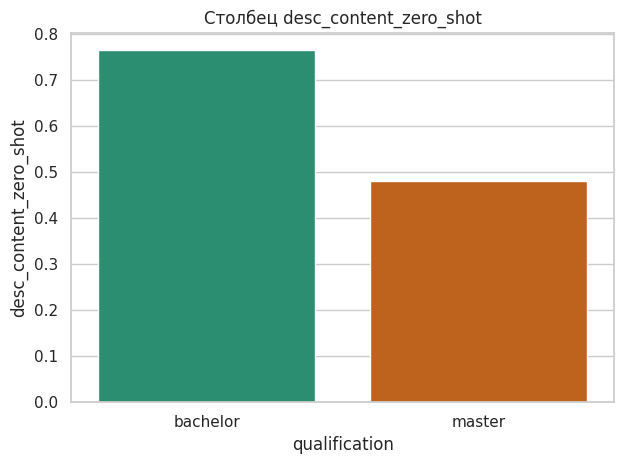

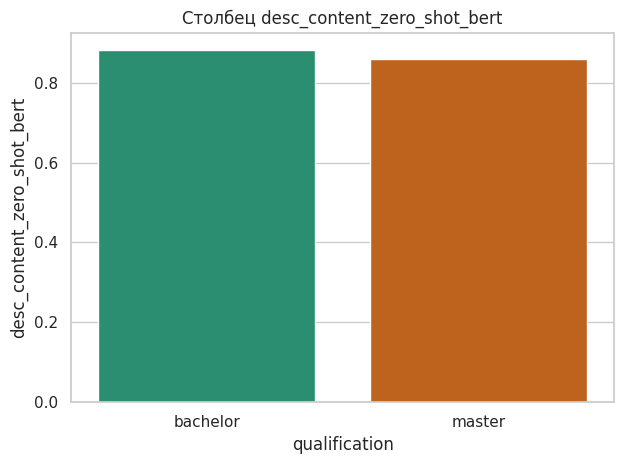

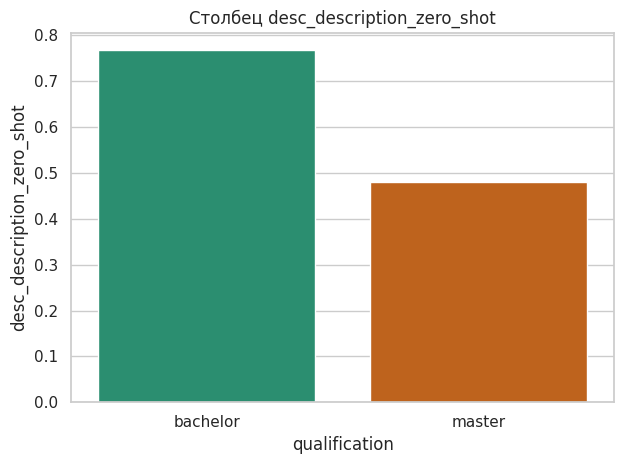

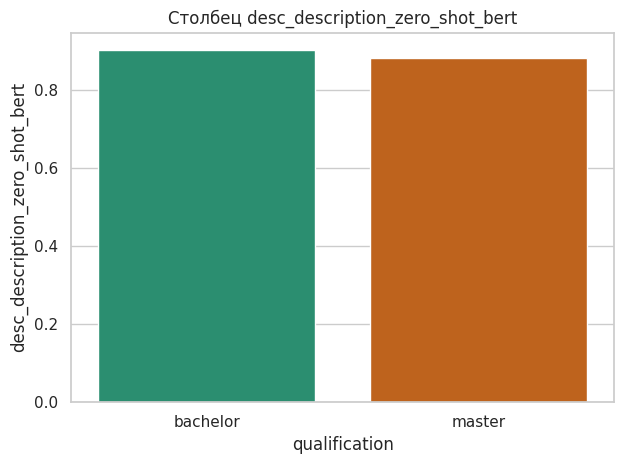

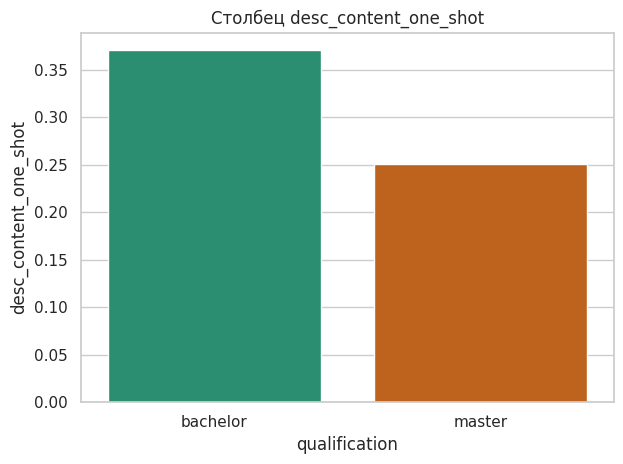

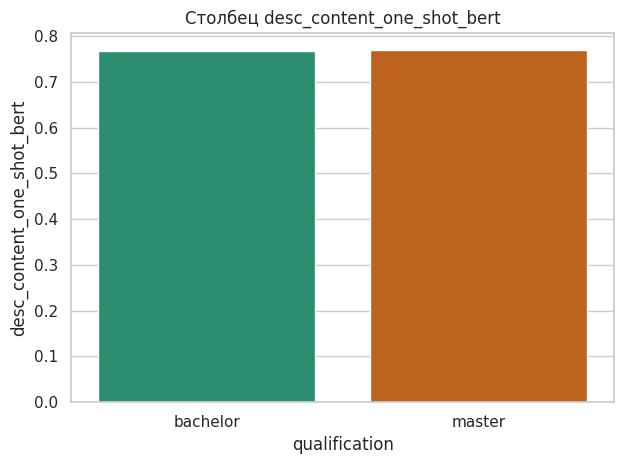

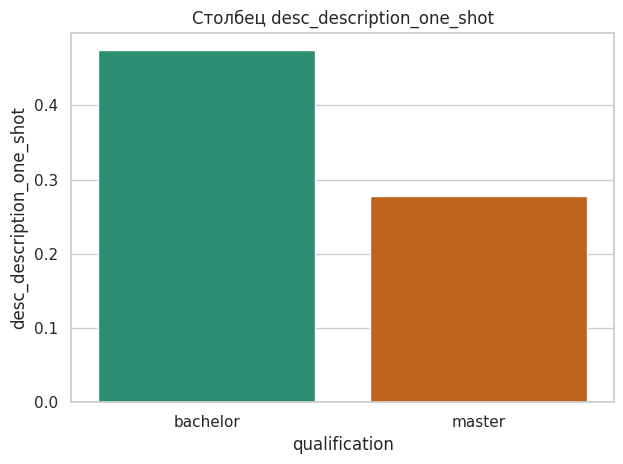

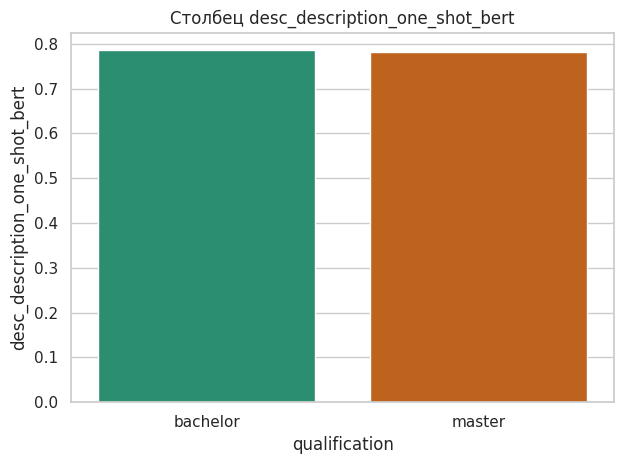

In [301]:
for column in ud_df_qualification.columns:
  if column == "qualification":
    continue
  plt.figure()
  sns.barplot(x="qualification", y=column, hue="qualification", data=ud_df_qualification)
  plt.title(f'Столбец {column}')
  plt.tight_layout()
  print()
  plt.show()

Вывод: можно заметить, что у некоторых моделей и методов векторизации, работающих в совокупности, есть идентичность значений, однако, если мы посомтрим на все графики в совокупности, то сможем сразу заметить отклонения для квалификации "Магистратура", поэтому, подытожив, можно сказать, что наилучшим образом сгенерированы краткие описания и содержания для программ бакалавриата, нежели для магистратуры

3. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по году (`start_year`). Сравните результаты для обоих векторайзеров.

In [302]:
ud_df_start_year = ud_df.groupby("start_year").agg({
    "desc_content_zero_shot": "mean",
    "desc_content_zero_shot_bert": "mean",
    "desc_description_zero_shot": "mean",
    "desc_description_zero_shot_bert": "mean",
    "desc_content_one_shot": "mean",
    "desc_content_one_shot_bert": "mean",
    "desc_description_one_shot": "mean",
    "desc_description_one_shot_bert": "mean"
}).reset_index()

ud_df_start_year

,start_year,desc_content_zero_shot,desc_content_zero_shot_bert,desc_description_zero_shot,desc_description_zero_shot_bert,desc_content_one_shot,desc_content_one_shot_bert,desc_description_one_shot,desc_description_one_shot_bert
0,2018,0.777467,0.894359,0.795576,0.905035,0.468509,0.803669,0.564414,0.806334
1,2019,0.801486,0.879579,0.766923,0.901243,0.359330,0.755497,0.462272,0.774169
2,2020,0.728282,0.882373,0.775400,0.901908,0.401103,0.777628,0.478430,0.788538
3,2021,0.371085,0.846547,0.337868,0.871622,0.132714,0.756392,0.155038,0.777671
4,2022,0.347390,0.837886,0.445282,0.880852,0.227379,0.758968,0.278510,0.792958


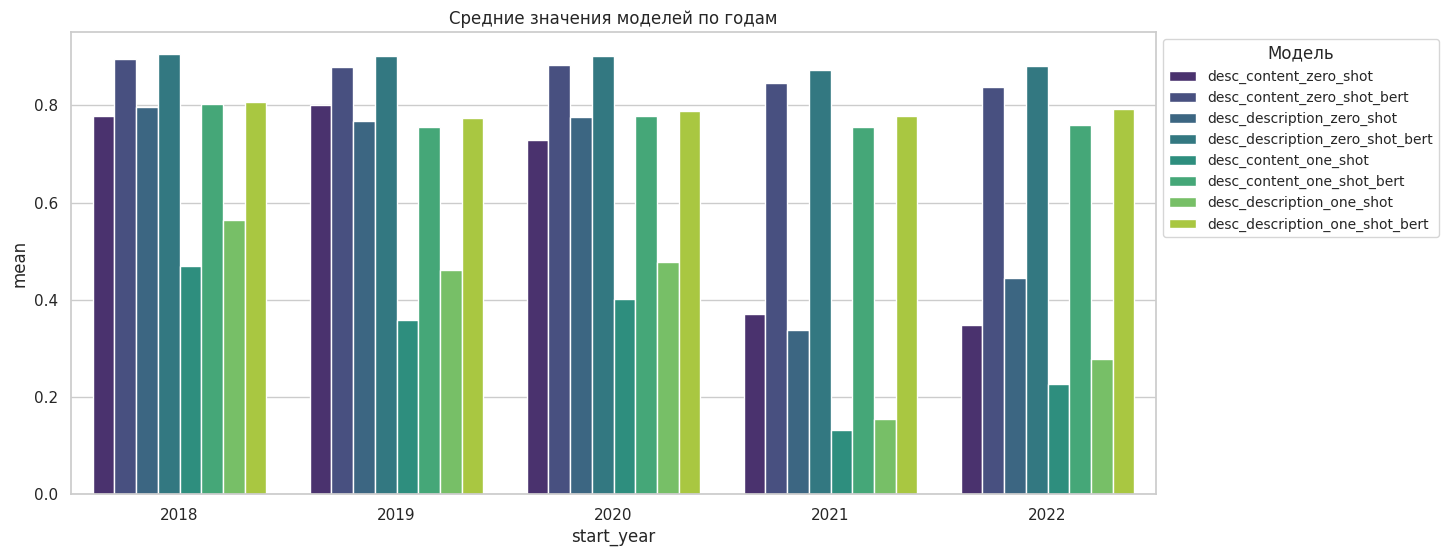

In [328]:
melted_df = ud_df_start_year.melt(
    id_vars=["start_year"],
    var_name="model",
    value_name="mean")

palette = sns.color_palette("viridis", len(melted_df["model"].unique()))
plt.figure(figsize=(14, 6))
sns.barplot(
    x="start_year",
    y="mean",
    hue="model",
    data=melted_df,
    palette=palette)

plt.title("Средние значения моделей по годам")
plt.legend(title="Модель", title_fontsize=12, fontsize=10, loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


Вывод: на мой взгляд, на протяжении годов отслеживается некоторая закономерность (некоторые значения остаются также на высоте, а некоторые все еще низко). Однако есть уникальные случаи, такие как, например, desc_content_zero_shot (это zero_shot + w2v), так как в 2018-2020 годах покзаатель держится на высоких позициях, а далее следует резкий скачок. Аналогично происходит и с desc_content_one_shot (one_shot + w2v). Если отмечать самые стабильные показатели за весь период, среди них desc_content_zero_shot_bert, desc_description_zero_shot_bert, desc_content_one_shot_bert, desc_description_one_shot_bert. Таким образом, при использовании векторизации от Tiny BERT разница в среднем косинусном сходстве на протяжении 2018-2022 не имеет сильного разброса, что говорит нам о его повышенной стабильности в сравнении с w2v

4. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по уровням образования и годам, но только с помощью векторов  w2v.

In [306]:
ud_df_start_year_and_qualification = ud_df.groupby(['qualification', 'start_year']).agg({
    "desc_content_zero_shot": "mean",
    "desc_description_zero_shot": "mean",
    "desc_content_one_shot": "mean",
    "desc_description_one_shot": "mean",
}).reset_index()


ud_df_start_year_and_qualification

,qualification,start_year,desc_content_zero_shot,desc_description_zero_shot,desc_content_one_shot,desc_description_one_shot
0,bachelor,2018,0.777467,0.795576,0.468509,0.564414
1,bachelor,2019,0.801486,0.766923,0.359330,0.462272
2,bachelor,2020,0.698069,0.717972,0.284375,0.385437
3,bachelor,2021,0.845215,0.833794,0.490850,0.614174
4,bachelor,2022,0.551823,0.851209,0.323143,0.496470
5,master,2020,0.752830,0.822060,0.495945,0.553988
6,master,2021,0.333155,0.298194,0.104064,0.118307
7,master,2022,0.142957,0.039354,0.131615,0.060551


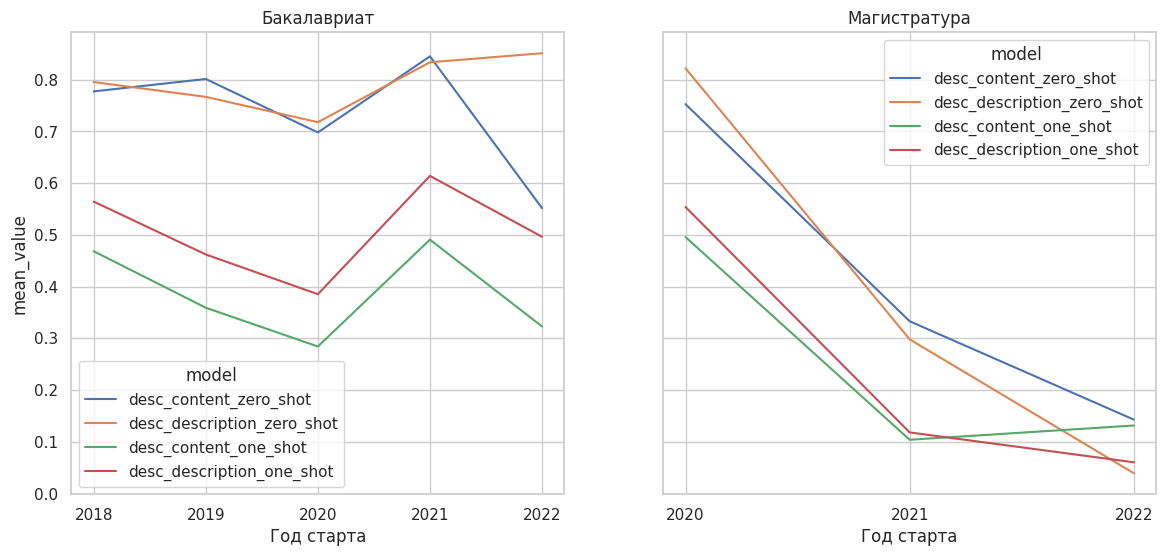

In [326]:
bachelor_df = ud_df_start_year_and_qualification[ud_df_start_year_and_qualification['qualification'] == 'bachelor']
master_df = ud_df_start_year_and_qualification[ud_df_start_year_and_qualification['qualification'] == 'master']

bachelor_melted = bachelor_df.melt(id_vars=["qualification", "start_year"], var_name="model", value_name="mean_value")
master_melted = master_df.melt(id_vars=["qualification", "start_year"], var_name="model", value_name="mean_value")

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sns.lineplot(
    x="start_year",
    y="mean_value",
    hue="model",
    data=bachelor_melted,
    ax=axes[0],
    markers=True)
axes[0].set_title("Бакалавриат")

sns.lineplot(
    x="start_year",
    y="mean_value",
    hue="model",
    data=master_melted,
    ax=axes[1],
    markers=True)
axes[1].set_title("Магистратура")

for ax in axes:
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_xlabel("Год старта")
plt.show()

Вывод: сразу можно заметить, что в 2018 и 2019 годах не было значений про магистратуру. Также для магистратуры можно увидеть сильное падение значения среднего косинусного сходства в 2021 году у обеих техник генерации, а что касается максимального значения, то его можно наблюдать в 2020. Если оценивать бакалавриат, то заметна нестабильность и постоянные скачки и спады. Из интересных наблюдений - стабильные синхронные показатели у one shot (и для краткого содержания, и для описания графики идут одинаково), а вот модель zero_shot показывает себя крайне непредсказуемо, что свидетельствует о ее постоянных изменениях. Однако даже не смотря на такую нестабильность, ее показатели все равно остаются амымми высокими, что свидетельствует нам о наибольшей точности

5. Оцените средние значения сходства эталонных данных и генераций обеими техниками в разрезе по уровню образования (`qualification`). То есть постройте такую диграмму, по которой будет видно, для какого уровня образования какая из техник в среднем дает более близкий к эталонному контекст.

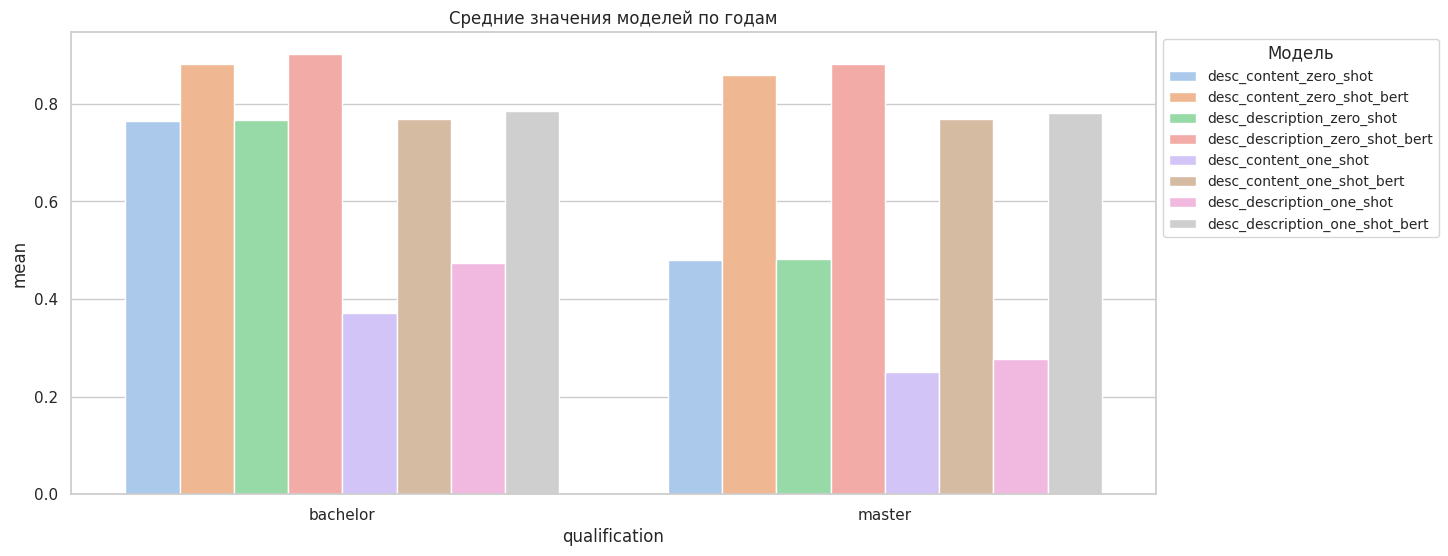

In [330]:
melted_df = ud_df_qualification.melt(
    id_vars=["qualification"],
    var_name="model",
    value_name="mean")

palette = sns.color_palette("pastel", len(melted_df["model"].unique()))
plt.figure(figsize=(14, 6))
sns.barplot(
    x="qualification",
    y="mean",
    hue="model",
    data=melted_df,
    palette=palette)

plt.title("Средние значения моделей по годам")
plt.legend(title="Модель", title_fontsize=12, fontsize=10, loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


Вывод: для реализации графика я использовала уже готовые данные, полученные в пункте 1, но внесла коррективы в визуализацию. Теперь становится более наглядно, что и для магистратуры, и для бакалавриата генерация краткого содержания и описания имеет наибольшее среднее косинусное сходство при помощи использования zero_shot и Tiny BERT

## Куда сдавать?

По инструкции в гитхаб – https://shy-question-39d.notion.site/1150ea832e418032bfc3d3e827c380fb?pvs=74

- К этой работе тестов нет.
- Эту работу можно выполнить с кем-нибудь в паре или в гордом одиночестве.
- Пул-реквест нужно сделать в ветку `lab4`. Если вас двое, то можно 1 или 2 пул-реквеста, главное – отметьте как-нибудь, что выполняли в паре.

**Устная защита работ не требуется, но вам могут быть заданы вопросы прямо в вашем пул-реквесте!**